In [16]:
import numpy as np
import astropy
import astropy.coordinates as ac
import astropy.units as u
import astropy.io
import astropy.table
import scipy
import pandas as pd
import galstreams
import gcutils
import gala
import gala.coordinates as gc
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [140]:
def mean_of_skycoords(coo):
    """
    Compute vector mean of SkyCoord inputs. Returns SkyCoord object
    """
    sum_coo = ac.SkyCoord(x=np.sum(coo.cartesian.x),
                          y=np.sum(coo.cartesian.y),
                          z=np.sum(coo.cartesian.z),
                          frame=ac.ICRS, representation_type='cartesian')
    #Surely there's a more elegant way of doing this. No patience right now. This is pretty clearly right.
    sum_coo = ac.SkyCoord(ra=sum_coo.spherical.lon, dec=sum_coo.spherical.lat)
    #sum_coo = sum_coo.unitspherical ?
    
    return sum_coo

def get_track_from_points(sc, N=200, deg=7):
    """ Estimate the mean track from a set of stream stars or points 

        Parameters
        ----------
        sc : `astropy.coordinates.SkyCoord` instance 

    """
    
    
    #find mean
    center=mean_of_skycoords(sc)
    #to get the extremes I should wrap the angles at the center and then get min/max. this is general
    if sc.ra.size<10: aux = ac.SkyCoord(ra=sc[[0,-1]].ra.value,dec=sc[[0,-1]].dec.value,unit=u.deg)
    else: aux = ac.SkyCoord(ra=sc[[5,-5]].ra.value,dec=sc[[5,-5]].dec.value,unit=u.deg)
    
    
    pole = gc.greatcircle.pole_from_endpoints(aux[0],aux[1])
    fr = gc.GreatCircleICRSFrame(pole=pole,ra0=center.ra)
    scp = sc.transform_to(fr)
    
    phi1s = np.linspace(np.min(scp.phi1),np.max(scp.phi1),N)
    phi2_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.phi2.deg, deg=deg))

    phi1_end_points = phi1s[[0,-1]]
    
    mean_phi1 = np.mean(phi1_end_points)
    phi2_mid = phi2_fit(mean_phi1.value)*scp.phi2.unit

    track_mid_point = ac.SkyCoord(phi1=mean_phi1, phi2=phi2_mid, frame=fr)
    
    #Initial track object
    track = ac.SkyCoord(phi1=phi1s, phi2=phi2_fit(phi1s.value)*u.deg, frame=fr)

    #Recompute the track using two points in the track, close to the center, at both sides (this ensures mid point is close to phi2=0)
    two_points_near_mid = ac.SkyCoord(phi1=[-0.5,0.5]*u.deg, phi2=phi2_fit([-0.5,0.5])*u.deg, frame=fr)
    two_points_near_mid = ac.SkyCoord(phi1=[mean_phi1-0.5*u.deg,mean_phi1+0.5*u.deg]*u.deg, phi2=phi2_fit([mean_phi1.deg-0.5,mean_phi1.deg+0.5])*u.deg, frame=fr)
    aux=ac.SkyCoord(ra=two_points_near_mid.transform_to(ac.ICRS).ra.value, dec=two_points_near_mid.transform_to(ac.ICRS).dec.value, unit=u.deg)
    #aux=two_points_near_mid.icrs
    new_pole = gc.greatcircle.pole_from_endpoints(aux[0],aux[1])
    
    #New stream's frame -------------------------------------------------------------------
    new_fr = gc.GreatCircleICRSFrame(pole=new_pole, ra0=track_mid_point.transform_to(ac.ICRS).ra)
    scp = sc.transform_to(new_fr)

    phi1s = np.linspace(np.min(scp.phi1),np.max(scp.phi1),N)
    phi1_end_points = phi1s[[0,-1]]
    
    #Set up polynomial fit with explicit frame so it can take a SkyCoord object in any frame and do it's magic
    phi2_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.phi2.value, deg=deg))
    phi2_track = phi2_fit(phi1s.deg)*scp.phi2.unit
    phi2_end = phi2_track[[0,-1]]
    mean_phi1 = np.mean(phi1_end_points)
    phi2_mid = phi2_fit([mean_phi1.value,])*scp.phi2.unit
    
    #In general phi1=0 in the initial guess frame is not necesarily contained between the end points
    
    mid_dict = dict(frame=new_fr, phi1=mean_phi1, phi2=phi2_mid)
    end_dict = dict(frame=new_fr, phi1= phi1_end_points, phi2=phi2_end)
    track_dict = dict(frame=new_fr, phi1 = phi1s, phi2 = phi2_track)
    fits = dict(phi2=phi2_fit)
    
    for att in ["distance", "pm_phi1_cosphi2", "pm_phi2",  "radial_velocity"]:
        if att=="distance" or 's' in scp.data.differentials:  #i.e. if obj contains velocity data
            att_fit = np.poly1d(np.polyfit(scp.phi1.deg, getattr(scp,att).value, deg=deg))  #polynomial fit obj
            track_dict[att] = att_fit(phi1s.deg)*getattr(scp,att).unit   #eval track-fit to get track for current attr
            mid_dict[att] = att_fit([mean_phi1.value,])*getattr(scp,att).unit
            end_dict[att] = att_fit(phi1_end_points.deg)*getattr(scp,att).unit
        else:
            fits[att] = None
            track_dict[att] = None
            mid_dict[att] = None
            end_dict[att] = None

    newtrack = ac.SkyCoord(**track_dict)       
    track_end_points = ac.SkyCoord(**end_dict)
    track_mid_point = ac.SkyCoord(**mid_dict)
 
    #Re-recompute stream frame to make sure mid_point ends up at phi1=0
    new_fr = gc.GreatCircleICRSFrame(pole=new_pole, ra0=track_mid_point.transform_to(ac.ICRS).ra[0])


    #Store width track
    track_width = np.std(scp.phi2)*np.ones(newtrack.phi2.size)  #TODO: turn this into rolling std
    
    #Re-store so that new_pole is iterable. Saves me trouble later
    new_pole = ac.SkyCoord(ra=np.array([new_pole.ra.deg,]), dec=np.array([new_pole.dec.deg,]), unit=u.deg)

    return (newtrack.transform_to(ac.ICRS), track_width, track_end_points.transform_to(ac.ICRS), track_mid_point.transform_to(ac.ICRS), 
            new_pole.transform_to(ac.ICRS), new_fr, fits)


In [18]:
def save_track_ecsv(outfilen,track):
    
    #Save track
    names = track.get_representation_component_names()
    names.update(track.get_representation_component_names('s'))
    t = astropy.table.QTable( {k: getattr(track, k) for k in names})
    astropy.io.ascii.write(t, format='ecsv', delimiter=',', output=outfilen, overwrite=True, fast_writer=False)   


def save_summary_ecsv(outfilen, track_end_points, track_mid_point, mid_pole, StreamName="0", StreamShortName="0"):
    
    #Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
    #ofilesn = f"{ofileroot}.summary.ecsv"
    names = track_end_points.get_representation_component_names()
    names.update(track_end_points.get_representation_component_names('s'))
    
    
    tr_summary = dict(StreamName=np.array([StreamName,]), StreamShortName=np.array([StreamShortName,]))
    lnames = [ "end_o."+k for k in names]
    tr_summary.update({l: getattr(track_end_points[:1], k) for k,l in zip(names,lnames)})
    lnames = [ "end_f."+k for k in names]
    tr_summary.update({l: getattr(track_end_points[1:], k) for k,l in zip(names,lnames)})
    lnames = [ "mid."+k for k in names]
    tr_summary.update({l: getattr(track_mid_point[:1], k) for k,l in zip(names,lnames)})
    rnames = mid_pole.get_representation_component_names()
    lnames = [ "pole."+k for k in rnames]
    tr_summary.update({l: getattr(mid_pole[:1], k) for k,l in zip(rnames,lnames)})
    #print track summary
    t = astropy.table.QTable(tr_summary)
    astropy.io.ascii.write(t, format='ecsv', delimiter=',', output=outfilen, overwrite=True, fast_writer=False)   
    

In [19]:
def stream_plot(stream_sc, track, track_end_points, track_mid_point, stream_fr, saveplot=False, clf=False, StreamName=None, plotfilen='salida.png', plot_obs=True):
    
    pkwds=dict(marker='.',ls='', alpha=0.5)
    tkwds=dict(marker='',ls='-', lw=2, color='orange')
    mkw=dict(marker='D',ls='', color='k')
    ekw=dict(marker='o',ls='', color='k')

    nx, ny = 2, 5
    fig=plt.figure(1,figsize=(10,10))
    axs = fig.subplots(ny,nx, sharex="col")

    if plot_obs: stream_plot_card(stream_sc, stream_fr, axs, plotkwds=pkwds )
    stream_plot_card(track, stream_fr, axs, plotkwds=tkwds)
    stream_plot_card(track_end_points, stream_fr, axs, plotkwds=ekw)
    stream_plot_card(track_mid_point, stream_fr, axs, plotkwds=mkw, show_labels=True)
    
    if StreamName: fig.suptitle("Stream: "+StreamName) 

    fig.tight_layout(rect=[0,0,1,0.97])

    if saveplot: fig.savefig(plotfilen)
    if clf:     fig.clf()


In [20]:
def stream_plot_card(sc, stream_fr, axs, plotkwds={}, show_labels=False, show_grid=False):

    

    labels1=dict(phi2="$\phi_2$ ($\degree$)", distance="$D$ (kpc)", 
                 pm_phi1_cosphi2="$\mu\phi1$ (arcsec/yr)", pm_phi2="$\mu\phi2$ (arcsec/yr)",
                 radial_velocity="$v_r$ (km/s)")
    labels2=dict(ra="$\\alpha$ ($\degree$)",dec="$\delta$ ($\degree$)", distance="$D$ (kpc)", 
                 pm_ra_cosdec="$\mu\\alpha$ (arcsec/yr)", pm_dec="$\mu\delta$ (arcsec/yr)",
                 radial_velocity="$v_r$ (km/s)")
    
    #Plots in stream frame coords    
    r,c=0,0    
    for att in ["phi2","distance", "pm_phi1_cosphi2", "pm_phi2",  "radial_velocity"]:
        try:
            if att=="distance" or 's' in sc.data.differentials:  #i.e. if obj contains velocity data
                axs[r,c].plot(sc.transform_to(stream_fr).phi1, getattr(sc.transform_to(stream_fr),att), **plotkwds)
                if (np.abs(getattr(sc.transform_to(stream_fr),att).value)>1e-10).sum()==0 :
                    axs[r,0].set_ylim(-10,10)
        except TypeError or ValueError: print("No kinematic data...")        
        if show_grid: axs[r,c].grid()
        if show_labels:
            if axs[r,c].is_last_row(): axs[r,c].set_xlabel("$\phi_1$ ($\degree$)")
            axs[r,c].set_ylabel(labels1[att])
        r=r+1

    #Plots in equatorial coords
    r,c=0,1  
    for att in ["dec","distance", "pm_ra_cosdec", "pm_dec",  "radial_velocity"]:
        try:
            #if hasattr(sc.icrs, att): 
            if att=="distance" or 's' in sc.data.differentials:  #i.e. if obj contains velocity data
                axs[r,c].plot(sc.icrs.ra, getattr(sc.icrs,att), **plotkwds)
                if (np.abs(getattr(sc.icrs,att).value)>1e-10).sum()==0 :
                    #axs[r,0].set_ylim(-10,10)
                    axs[r,1].set_ylim(-10,10)       
        except TypeError or ValueError: print("No kinematic data...")                        
        if show_grid: axs[r,c].grid()
        if show_labels:
            if axs[r,c].is_last_row(): axs[r,c].set_xlabel("$\\alpha$ ($\degree$)")
            axs[r,c].set_ylabel(labels2[att])
            
        r=r+1
    
    #return f, axs

In [129]:
def generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, deg=3, ShortName=None, clf=True, plot_obs=True, plot_ext=".st", verbose=True):
    '''
        Generate track from points, plot it and store track and track summary in ecsv files
        
        Parameters:
        
        obs: SkyCoord Object. Must contain velocity data
        
        Name: String - Stream's name
        
        Ref: String - Main Reference for stream track
        
        Optional:
        
        mid_point: SkyCoord - not implemented yet. When it is it will override the auto-computed mid_point
    '''
    
    if ShortName is None:  ShortName=Name[:3]

    track, track_width, track_end_points, track_mid_point, mid_pole, stream_fr, track_fits = get_track_from_points(obs.icrs, deg=deg)

    #Print track out
    ofileroot = f"track{plot_ext}.{Name}.{Ref.lower()}"
    if verbose: print(f"{Name} -> {ofileroot}.ecsv")
    save_track_ecsv(f"{ofileroot}.ecsv",track)

    #Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
    ofilesn = f"{ofileroot}.summary.ecsv"    
    save_summary_ecsv(ofilesn, track_end_points, track_mid_point, mid_pole, StreamName=Name, StreamShortName=ShortName )

    #While we're at it. Make plot and save
    stream_plot(obs, track, track_end_points, track_mid_point, stream_fr, saveplot=True, plotfilen=ofileroot+".png",  clf=clf, StreamName=Name, plot_obs=plot_obs)
    
    #Save poly-footprint
    #here...



Tracks init by end points
==========================

In [22]:
tpair = astropy.io.ascii.read("../support_data/lib_by_pair.dat",header_start=4)
#tpair.replace_column('Ro', tpair["Ro"].astype(float))
tpair

Name,ShortName,lono,lato,lonf,latf,frame,Ro,Rf,Width,Reference
str11,str5,float64,float64,float64,float64,str3,float64,float64,float64,str26
Phoenix,Phe,20.0,-57.0,27.0,-45.0,equ,17.5,17.5,0.18,Balbinot2016
Acheron,Ach,230.0,-2.0,259.0,21.0,equ,3.5,3.8,0.9,Grillmair2009
Cocytos,Coc,186.0,-3.0,259.0,20.0,equ,11.0,11.0,0.7,Grillmair2009
Lethe,Let,171.0,18.0,258.0,20.0,equ,13.0,13.0,0.4,Grillmair2009
Styx,Sty,194.0,20.0,259.0,21.0,equ,45.0,45.0,3.3,Grillmair2009
ACS,ACS,126.4,-0.7,133.9,64.2,equ,8.9,8.9,5.0,Grillmair2006
Pal15,Pal15,254.8,-0.12,255.3,-1.47,equ,38.4,38.4,0.0,Myeong2017
Eridanus,Eri,65.98,-21.42,66.4,-20.96,equ,95.0,95.0,0.0,Myeong2017
TucanaIII,Tuc3,-6.3,-59.7,3.2,-59.4,equ,23.0,27.0,0.18,"Shipp2018,DrlicaWagner2015"


In [264]:
gcstep=0.1
coo_frame=dict(equ="icrs",gal="galactic",Galactocentric="GC")

for i in range(tpair["lono"].size)[:]:

    Name, ShortName, Reference = tpair["Name"][i], tpair["ShortName"][i], tpair["Reference"][i] 
    print(i,Name)

    #End points
    track_end_point_o = ac.SkyCoord(tpair["lono"][i]*u.deg ,tpair["lato"][i]*u.deg, frame=coo_frame[tpair["frame"][i]])
    track_end_point_f = ac.SkyCoord(tpair["lonf"][i]*u.deg ,tpair["latf"][i]*u.deg, frame=coo_frame[tpair["frame"][i]])

    track_end_points = ac.SkyCoord(np.array([tpair["lono"][i],tpair["lonf"][i]])*u.deg,
                                   np.array([tpair["lato"][i],tpair["latf"][i]])*u.deg,
                                   distance=np.array([tpair["Ro"][i],tpair["Rf"][i]])*u.kpc,
                                   frame=coo_frame[tpair["frame"][i]],
                                   pm_ra_cosdec=np.zeros(2)*u.arcsec/u.yr, 
                                   pm_dec=np.zeros(2)*u.arcsec/u.yr)

    
    #Mid point. This track is, by definitiion a great circle. In this case, it is valid that the mean will be in the same plane and thus a valid mid-point
    track_mid_point = mean_of_skycoords(track_end_points)   
    
    mid_pole = gc.greatcircle.pole_from_endpoints(track_end_point_o, track_end_point_f)
    stream_fr = gc.GreatCircleICRSFrame(pole=mid_pole, ra0=track_mid_point.ra)
    
    #Generate sky track
    phis_o=np.linspace( (track_end_points.transform_to(stream_fr).phi1.value).min(),  (track_end_points.transform_to(stream_fr).phi1.value).max(), 200)
    phi1s = phis_o*track_end_points.ra.unit
    phi2 = np.zeros(phi1s.size)*phi1s.unit
    
    #Distance track - If a detailed track is lacking and only Ro,Rf are reported, nothing better to do than linear interpolation
    Fd = scipy.interpolate.interp1d([phis_o[0],phis_o[-1]],[tpair["Ro"][i],tpair["Rf"][i]],kind='linear',bounds_error=False)
    distance = Fd(phi1s.value)*u.kpc    #Ro,Rf are passed in kpc

    
    #In this category, for now it's assumed no proper motion data is available. If it is, move to Individual stream category
    track = ac.SkyCoord(phi1=phi1s, phi2=phi2, 
                        distance=distance,
                        frame=stream_fr, 
                        pm_phi1_cosphi2=np.zeros(phi2.size)*u.arcsec/u.yr, 
                        pm_phi2=np.zeros(phi2.size)*u.arcsec/u.yr)

    #Objects are stored in icrs by default
    track_mid_point = ac.SkyCoord(ra=track_mid_point.ra*np.ones(1), dec=track_mid_point.dec*np.ones(1), 
                                  distance=Fd(0.)*u.kpc, frame="icrs", 
                                  pm_ra_cosdec=np.zeros(1)*u.arcsec/u.yr, pm_dec=np.zeros(1)*u.arcsec/u.yr )    


    mid_pole = ac.SkyCoord(ra=mid_pole.ra*np.ones(1), dec=mid_pole.dec*np.ones(1), distance=np.zeros(1), frame="icrs", 
                           pm_ra_cosdec=np.zeros(1)*u.arcsec/u.yr, pm_dec=np.zeros(1)*u.arcsec/u.yr )


    ofileroot = f"track.ep.{Name}.{Reference.lower()}"

    #Save plots
    stream_plot(track, track, track_end_points, track_mid_point, stream_fr, saveplot=True, plotfilen=ofileroot+".png", clf=True, StreamName=Name, plot_obs=False)

    #Print track out
    ofileroot = f"track.ep.{Name}.{Reference.lower()}"
    print(f"{Name} -> {ofileroot}.ecsv")
    save_track_ecsv(f"{ofileroot}.ecsv",track = track.icrs)

    #Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
    ofilesn = f"{ofileroot}.summary.ecsv"    
    save_summary_ecsv(ofilesn, track_end_points.icrs, track_mid_point.icrs, mid_pole.icrs, StreamName=Name, StreamShortName=ShortName )
    



0 Phoenix
Phoenix -> track.ep.Phoenix.balbinot2016.ecsv
1 Acheron
Acheron -> track.ep.Acheron.grillmair2009.ecsv
2 Cocytos
Cocytos -> track.ep.Cocytos.grillmair2009.ecsv
3 Lethe
Lethe -> track.ep.Lethe.grillmair2009.ecsv
4 Styx
Styx -> track.ep.Styx.grillmair2009.ecsv
5 ACS
ACS -> track.ep.ACS.grillmair2006.ecsv
6 Pal15
Pal15 -> track.ep.Pal15.myeong2017.ecsv
7 Eridanus
Eridanus -> track.ep.Eridanus.myeong2017.ecsv
8 TucanaIII
TucanaIII -> track.ep.TucanaIII.shipp2018,drlicawagner2015.ecsv
9 Indus
Indus -> track.ep.Indus.shipp2018.ecsv
10 Jhelum
Jhelum -> track.ep.Jhelum.shipp2018.ecsv
11 Ravi
Ravi -> track.ep.Ravi.shipp2018.ecsv
12 Chenab
Chenab -> track.ep.Chenab.shipp2018.ecsv
13 Elqui
Elqui -> track.ep.Elqui.shipp2018.ecsv
14 Aliqa_Uma
Aliqa_Uma -> track.ep.Aliqa_Uma.shipp2018.ecsv
15 Turbio
Turbio -> track.ep.Turbio.shipp2018.ecsv
16 Willka_Yaku
Willka_Yaku -> track.ep.Willka_Yaku.shipp2018.ecsv
17 Turranburra
Turranburra -> track.ep.Turranburra.shipp2018.ecsv
18 Wambelong
Wambelo

<Figure size 720x720 with 0 Axes>

In [95]:
mwsts=galstreams.MWStreams(verbose=False)

/Users/cmateu/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


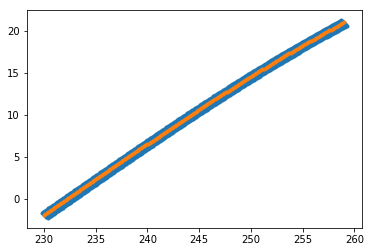

In [10]:
#Read-in validation
ofilen="track.ep.Acheron.grillmair2009.ecsv"
t = astropy.table.QTable.read(ofilen)
sc = ac.SkyCoord(**t)

#rr=astropy.io.ascii.read(ofilen, format='ecsv')   
#rr["sc"].ra
plt.plot(mwsts["Acheron"].ra,mwsts["Acheron"].dec,'.')
plt.plot(sc.ra.deg,sc.dec.deg,'.')

Tracks init by pole
====================

In [144]:
tpoles = astropy.io.ascii.read("../support_data/lib_by_pole.dat",header_start=2)
tpoles

Name,pole_lon,pole_lat,pole_frame,center_lon,center_lat,cent_frame,dlon_deg,dlat,Ro,Rf,ShortName,Reference
str9,float64,float64,str3,float64,float64,str3,float64,float64,float64,float64,str6,str13
PS1-A,300.856,20.732,equ,160.17,-62.27,gal,5.0,0.45,7.9,7.9,PS1-A,Bernard2016
PS1-B,65.603,32.567,equ,248.41,32.3,gal,10.0,0.45,14.5,14.5,PS1-B,Bernard2016
PS1-C,232.227,33.838,equ,75.12,-32.6,gal,8.0,0.333,17.4,17.4,PS1-C,Bernard2016
PS1-D,49.64,2.467,equ,231.06,32.83,gal,45.0,0.867,22.9,22.9,PS1-D,Bernard2016
PS1-E,42.526,23.987,equ,144.17,58.4,gal,25.0,0.617,12.6,12.6,PS1-E,Bernard2016
ATLAS,77.16,46.92,equ,25.0,-30.0,equ,12.0,0.25,20.0,20.0,ATLAS,Koposov2014
Ophiuchus,184.32,77.25,equ,4.53,31.69,gal,2.5,0.12,9.5,9.5,Oph,Bernard2014
Sangarius,178.0,-52.0,gal,149.01,7.847,equ,59.0,0.44,21.0,21.0,San,Grillmair2017
Scamander,196.0,-41.0,gal,153.52,12.46,equ,66.0,0.22,21.0,21.0,Sca,Grillmair2017


In [145]:
coo_frame=dict(equ="icrs",gal="galactic",Galactocentric="GC")
gcstep=0.1
tp=tpoles
for i in range(tp["Name"].size)[:]:
    _ = ac.galactocentric_frame_defaults.set('v4.0') 
    Name, ShortName=tp["Name"][i], tp["ShortName"][i]
    Ref= tp["Reference"][i]
    
    print(Name)
    #Store pole and center coords, each in its own frame. 
    if "GC" not in tp["pole_frame"][i] and "GC" not in tp["cent_frame"][i]:
        pole_sc = ac.SkyCoord( tp["pole_lon"][i], tp["pole_lat"][i], unit=u.deg, frame=coo_frame[tp["pole_frame"][i]] )
        cent_sc = ac.SkyCoord( tp["center_lon"][i], tp["center_lat"][i], unit=u.deg, frame=coo_frame[tp["cent_frame"][i]] )
                             
        #Generate track from pole. Starting here, do everything in galactic
        azs,lats=gcutils.get_gc_for_pole(pole_sc.galactic.l.deg,pole_sc.galactic.b.deg,degree=True,
                                         center=[cent_sc.galactic.l.deg,cent_sc.galactic.b.deg],
                                         dlon=tp["dlon_deg"][i],dlat=0.,step=gcstep)
                                                                       
        distance = np.ones_like(azs)*tp["Ro"][i]   
        coo = ac.SkyCoord( l=azs*u.deg, b=lats*u.deg, frame="galactic", distance = distance*u.kpc,
                           pm_l_cosb=np.zeros(azs.size)*u.mas/u.yr, pm_b=np.zeros(azs.size)*u.mas/u.yr)
    else:
        if "GC" not in tp["cent_frame"][i]:
                cent_sc=ac.SkyCoord(tp["center_lon"][i]*u.deg, tp["center_lat"][i]*u.deg, frame=coo_frame[tp["cent_frame"][i]], 
                                    distance=tp["Ro"][i]*u.kpc)
                cent_in_GC=cent_sc.transform_to(ac.Galactocentric)                 
        azs,lats=gcutils.get_gc_for_pole( tp["pole_lon"][i],tp["pole_lat"][i],degree=True,
                                         center=[cent_in_GC.spherical.lon.deg,cent_in_GC.spherical.lat.deg],
                                         dlon=tp["dlon_deg"][i],dlat=0.,step=gcstep)
                                          
        distance=tp["Ro"][i]*np.ones_like(azs)                                                                     
        print(distance.mean(),azs.size)
        galcen = ac.SkyCoord(lon=azs*u.deg, lat=lats*u.deg, distance=distance*u.kpc, frame=ac.Galactocentric,  representation_type='spherical' )
        
        #Do it this way, instead of just gc.transform_to("galactic"), because extra info in SkyCoord obj due to Galactocentric initialization 
        #gives a RepresentationError when printing ecsv table
        coo = ac.SkyCoord(l=galcen.galactic.l, b=galcen.galactic.b, distance=galcen.galactic.distance, frame='galactic',
                          pm_l_cosb=np.zeros(distance.size)*u.mas/u.yr, pm_b=np.zeros(distance.size)*u.mas/u.yr)
    
    generate_track_from_points_plot_and_store(coo, Name, Ref, mid_point=None, ShortName=ShortName, deg=12, clf=True, plot_obs=True, plot_ext='.po')

#         #Save plots
#         stream_plot(track, track, track_end_points, track_mid_point, stream_fr, saveplot=True, plotfilen=ofileroot+".png", clf=True, StreamName=Name, plot_obs=False)

#         #Print track out
#         ofileroot = f"track.ep.{Name}.{Reference.lower()}"
#         print(f"{Name} -> {ofileroot}.ecsv")
#         save_track_ecsv(f"{ofileroot}.ecsv",track = track.icrs)

#         #Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
#         ofilesn = f"{ofileroot}.summary.ecsv"    
#         save_summary_ecsv(ofilesn, track_end_points.icrs, track_mid_point.icrs, mid_pole.icrs, StreamName=Name, StreamShortName=ShortName )
    

  
        
#     width = tp["dlat"][i]*np.ones(np.size(coo.l))*u.kpc 
    
    
#     #Print track
#     print(tp["Name"][i],np.size(azs))
#     ofilen="track.po.{Name}.{Ref}.ecsv".format(Name=tp["Name"][i], Ref=tp["Reference"][i].lower() )
#     print("{N} {Name} -> {ofn}".format(N=i, Name=tp["Name"][i], ofn=ofilen))
#     #as magic ECSV
#     t = astropy.table.QTable([coo, width], names=['sc', 'width'])
#     #t = astropy.table.QTable([coo], names=['sc'])

#     astropy.io.ascii.write(t, format='ecsv', delimiter=',', output=ofilen, overwrite=True)   
#     #print("printed")

PS1-A
PS1-A -> track.po.PS1-A.bernard2016.ecsv
PS1-B
PS1-B -> track.po.PS1-B.bernard2016.ecsv
PS1-C
PS1-C -> track.po.PS1-C.bernard2016.ecsv
PS1-D
PS1-D -> track.po.PS1-D.bernard2016.ecsv
PS1-E
PS1-E -> track.po.PS1-E.bernard2016.ecsv
ATLAS
ATLAS -> track.po.ATLAS.koposov2014.ecsv
Ophiuchus
Ophiuchus -> track.po.Ophiuchus.bernard2014.ecsv
Sangarius
Sangarius -> track.po.Sangarius.grillmair2017.ecsv
Scamander
Scamander -> track.po.Scamander.grillmair2017.ecsv
Corvus
11.0 799
Corvus -> track.po.Corvus.mateu2018.ecsv
20.0-1
20.0 496
20.0-1 -> track.po.20.0-1.mateu2018.ecsv


<Figure size 720x720 with 0 Axes>

Individually initialized tracks
===================================

Ibata 2020 streams
------------------

In [88]:
ibt=astropy.io.ascii.read("../support_data/tab01.Ibata2020.wnames.cat")
ib=ac.SkyCoord(ra=ibt["ra_epoch2000"]*u.deg, dec=ibt["dec_epoch2000"]*u.deg, distance=ibt["dis"]*u.kpc, 
                pm_ra_cosdec=ibt["pmra"]*u.mas/u.yr, pm_dec=ibt["pmdec"]*u.mas/u.yr)#, radial_velocity=np.zeros(ibt["dis"].size)*u.km/u.s)
ib.StreamName=ibt["StreamName"]

In [85]:
ibt

source_id,ra_epoch2000,dec_epoch2000,parallax,pmra,pmdec,Gmag0,BRcol0,dis,streamN,StreamName
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str10
4976492500371673600,0.5550946,-50.8463493,-0.155,8.388,-4.01,19.452,0.668,9.3,1,Jhelum
4973150156822139264,1.5151347,-51.9761751,0.174,6.889,-3.5,18.507,0.697,11.9,1,Jhelum
4973592611470354688,1.7731105,-50.8343482,0.14,7.972,-3.24,19.18,0.582,10.0,1,Jhelum
4973559626121475968,2.8546245,-50.7333002,0.43,7.136,-3.877,19.429,0.574,10.3,1,Jhelum
4973378962616486912,3.1114491,-50.6157726,0.121,7.975,-3.357,17.038,0.897,11.0,1,Jhelum
4973026771000769152,6.4565788,-50.2683395,0.144,7.061,-2.923,19.047,0.579,10.5,1,Jhelum
4974285024620094720,7.8035975,-50.4251735,0.068,8.163,-2.992,18.303,0.766,10.7,1,Jhelum
4926327870766845824,8.5414353,-50.4910177,-0.081,8.574,-3.006,18.42,0.646,10.4,1,Jhelum
4926678408817278208,10.4882421,-50.0127874,0.083,7.895,-2.535,18.458,0.652,10.7,1,Jhelum


Skipping excluded stream: VOD/VSS
Skipping excluded stream: Monoceros
Skipping excluded stream: Her-Aq
Skipping excluded stream: Sgr-L10


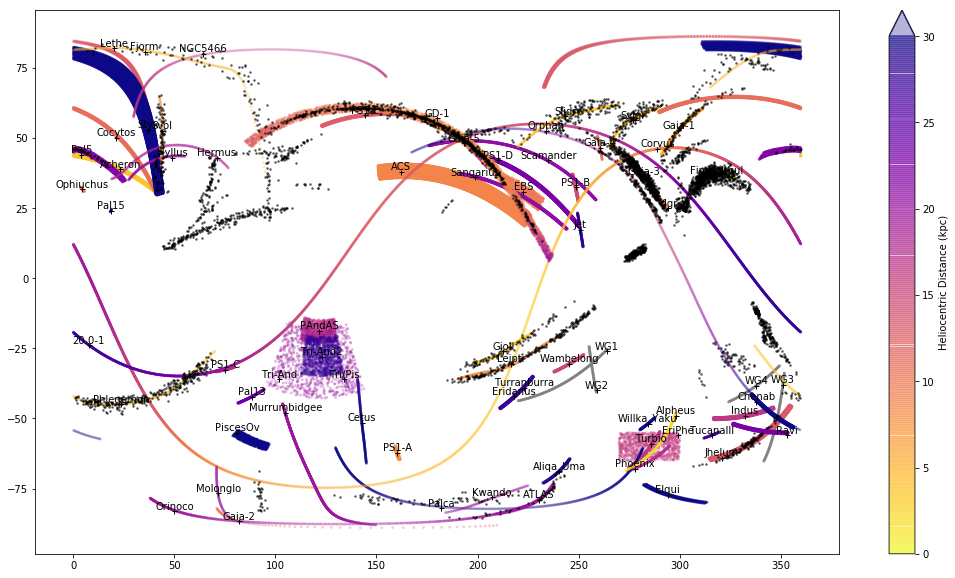

In [109]:
m=ib.StreamName=="GD-1"
#plt.plot(ib.galactic.l[m],ib.galactic.b[m],'.k')
fig=plt.figure(1,figsize=(18,10))
ax=fig.add_subplot(111)
cmapp=plt.cm.plasma_r
cmapp.set_under('grey')   #If distance info is missing (-1), plot in grey

mwsts.plot_stream_compilation(ax,plot_colorbar=True,scat_kwargs=dict(vmin=0.,vmax=30.,cmap=cmapp, alpha=0.3), exclude_streams=["Sgr-L10","Her-Aq","Monoceros","VOD/VSS"],
                                  use_shortnames=False, cb_kwargs=dict(label='Heliocentric Distance (kpc)'), 
                                  verbose=False)
ax.scatter(ib.galactic.l,ib.galactic.b,c='k',marker='.',s=10,alpha=0.5)



In [90]:
ib[m][-3]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (218.8535533, 58.7747837, 11.9)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-6.83, -1.416)>

In [14]:
#pole=gc.greatcircle.pole_from_endpoints(ib[m][0], ib[m][-3])

In [15]:
#np.unique(ib.stream)

In [92]:
i = 22 #8 22 #31
#It has to be done this way. I dont't know why, but using the full ib SKyCoord obj gives a representation error
#TypeError: Operation 'truediv' is not supported when differentials are attached to a CartesianRepresentation.
mask = ib.ra>195*u.deg
ibs = ib[m & mask]
Ref = "ibata2020"
for sname in np.unique(ib.StreamName)[:]:
    m = ib.StreamName==sname
    ibs = ib[m]
    Name=f"{sname}"

    generate_track_from_points_plot_and_store(ibs, Name, Ref, mid_point=None, ShortName=Name[:3], clf=True, plot_obs=True)


# Then, when reading it back in, it should be possible to do:
# t = at.QTable.read('filename.ecsv')
# sc = coord.SkyCoord(**t)




C-1 -> track.st.C-1.ibata2020.ecsv
C-2 -> track.st.C-2.ibata2020.ecsv
C-3 -> track.st.C-3.ibata2020.ecsv
C-4 -> track.st.C-4.ibata2020.ecsv
C-5 -> track.st.C-5.ibata2020.ecsv
C-6 -> track.st.C-6.ibata2020.ecsv
C-7 -> track.st.C-7.ibata2020.ecsv
C-8 -> track.st.C-8.ibata2020.ecsv
C-9 -> track.st.C-9.ibata2020.ecsv
Fimbulthul -> track.st.Fimbulthul.ibata2020.ecsv
Fjorm -> track.st.Fjorm.ibata2020.ecsv
GD-1 -> track.st.GD-1.ibata2020.ecsv
Gaia-1 -> track.st.Gaia-1.ibata2020.ecsv
Gaia-2 -> track.st.Gaia-2.ibata2020.ecsv
Gjoll -> track.st.Gjoll.ibata2020.ecsv
Gunnthra -> track.st.Gunnthra.ibata2020.ecsv
Hrid -> track.st.Hrid.ibata2020.ecsv
Jhelum -> track.st.Jhelum.ibata2020.ecsv
Kshir -> track.st.Kshir.ibata2020.ecsv
Leiptr -> track.st.Leiptr.ibata2020.ecsv
M68 -> track.st.M68.ibata2020.ecsv
M92 -> track.st.M92.ibata2020.ecsv
NGC3201 -> track.st.NGC3201.ibata2020.ecsv
NGC6397 -> track.st.NGC6397.ibata2020.ecsv
Orphan -> track.st.Orphan.ibata2020.ecsv
Pal-5 -> track.st.Pal-5.ibata2020.ecsv


<Figure size 720x720 with 0 Axes>

Alpheus
========

Alpheus -> track.st.Alpheus.grillmair2013.ecsv


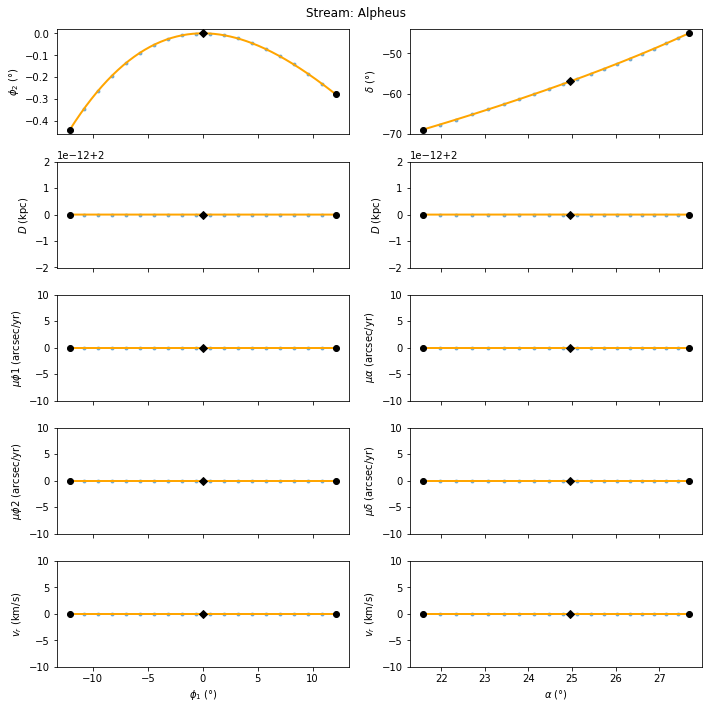

In [19]:
#Alpheus
dec=np.linspace(-69.,-45.,20)
ra = 32.116-0.00256*dec-0.00225*(dec**2)  #from Grillmair 2013
D = 2.*np.ones(ra.size)
zeros=np.zeros(ra.size)
Ref = "grillmair2013"
Name,ShortName= "Alpheus","Alp"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='icrs',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

Hermus
=======

- Distance gradient implemented 18.01.2021

Hermus -> track.st.Hermus.grillmair2014.ecsv


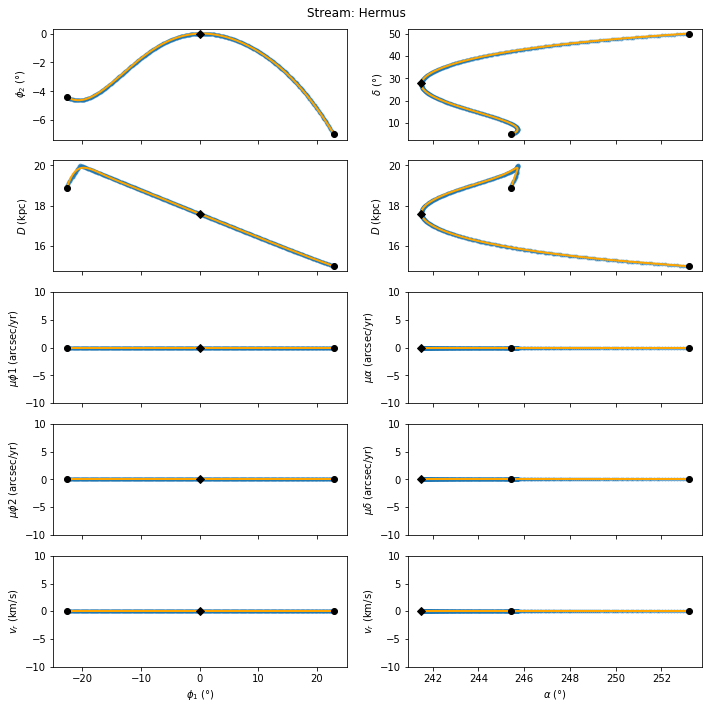

In [20]:

#Hermus
#from Grillmair 2014
N=500
dec=np.linspace(5.,+50.,500)
ra=241.571 + 1.37841*dec -0.148870*(dec**2) + 0.00589502*(dec**3) -1.03927E-4*(dec**4) + 7.28133E-7*(dec**5)
zeros=np.zeros(dec.size)
width=0.5*u.deg
#Grillmair says distance is: (15 north end, central 20, south 19) kpc
Fd = scipy.interpolate.interp1d([dec[0],dec[25],dec[-1]],[19.,20.,15.],kind='linear',bounds_error=False)
D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

#D = 18.+zeros

Ref = "grillmair2014"
Name,ShortName= "Hermus","Her"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, deg=10, ShortName=ShortName, clf=False, plot_obs=True)

Hyllus
=======

- Distance gradient implemented 18.01.2021

Hyllus -> track.st.Hyllus.grillmair2014.ecsv


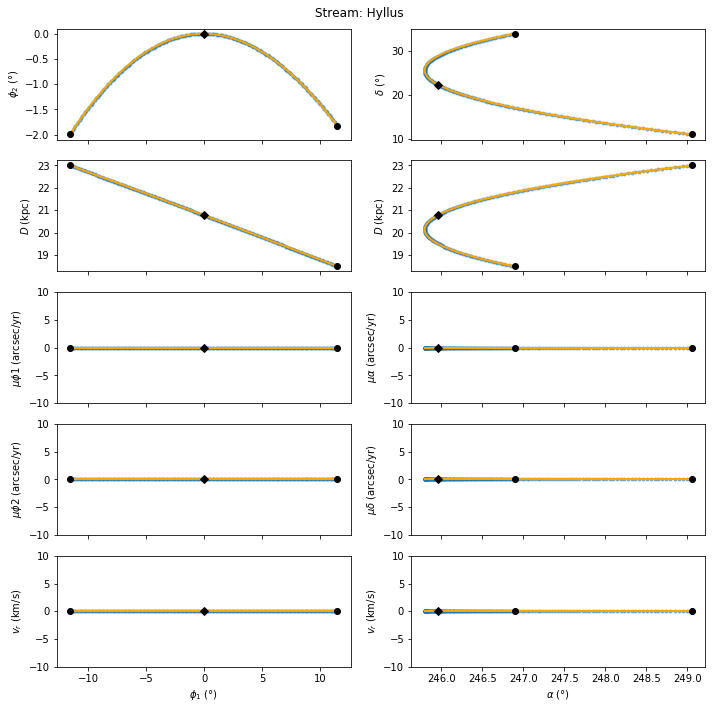

In [307]:
dec=np.linspace(11.,+34.,200)
ra=255.8150-0.78364*dec + 0.01532*dec**2
#D= north 18.5, south 23

zeros=np.zeros(ra.size)
width=0.5*u.deg
#Grillmair says distance is: (15 north end, central 20, south 19) kpc
Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

Ref = "grillmair2014"
Name,ShortName= "Hyllus","Hyl"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

Murrumbidgee
===========

Murrumbidgee -> track.st.Murrumbidgee.grillmair2017b.ecsv


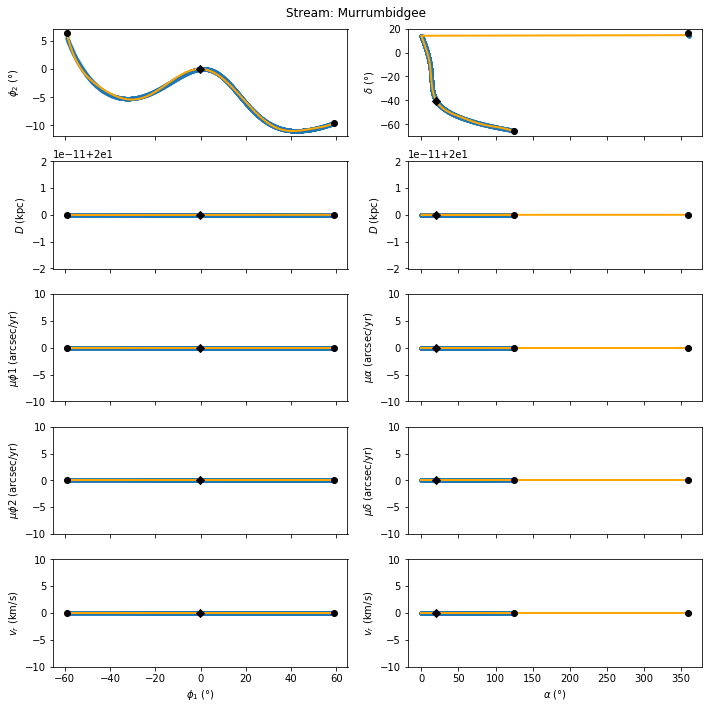

In [308]:
#Murrumbidgee, From Grillmair 2017b
dec=np.linspace(-65,+16.,3000)  
#dec range is not clear in G17's paper, the fiducial point is not included in the mentioned
#range -65<dec<-30.
#print bovyc.lb_to_radec(180.,-5.)
ra=367.893 -0.4647*dec -0.00862*dec**2 + 0.000118*dec**3 +1.2347e-6*dec**4 -1.13758e-7*dec**5
ra=ra % 360.

zeros=np.zeros(ra.size)
width=0.5*u.deg
D = 20.0+zeros
#Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
#D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

Ref = "grillmair2017b"
Name,ShortName= "Murrumbidgee","Mur"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, deg=8, ShortName=ShortName, clf=False, plot_obs=True)

Molonglo
====

Molonglo -> track.st.Molonglo.grillmair2017b.ecsv


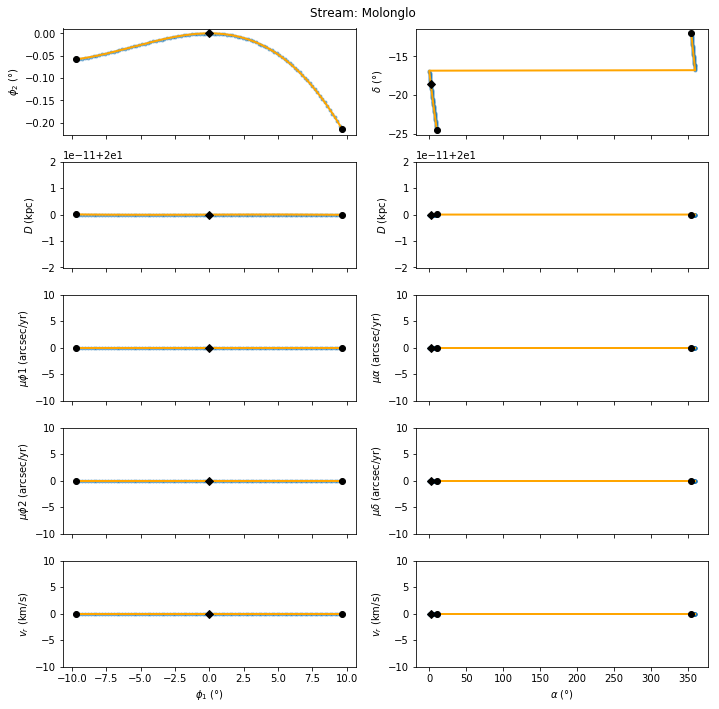

In [309]:
#Molonglo, From Grillmair 2017b
dec=np.linspace(-24.5,-12.,100)
ra=345.017 - 0.5843*dec + 0.0182*dec**2
ra=ra % 360.

zeros=np.zeros(ra.size)
#width=0.5*u.deg
D = 20.0+zeros
#Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
#D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

Ref = "grillmair2017b"
Name,ShortName= "Molonglo","Mol"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

track, track_width, track_end_points, track_mid_point, mid_pole, stream_fr, track_fits = get_track_from_points(obs.icrs, deg=3.)

#Print track out
ofileroot = f"track.st.{Name}.{Ref}"
print(f"{Name} -> {ofileroot}.ecsv")
save_track_ecsv(f"{ofileroot}.ecsv",track)

#Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
ofilesn = f"{ofileroot}.summary.ecsv"    
save_summary_ecsv(ofilesn, track_end_points, track_mid_point, mid_pole, StreamName=Name, StreamShortName=ShortName )

#While we're at it. Make plot and save
stream_plot(obs, track, track_end_points, track_mid_point, stream_fr, saveplot=True, plotfilen=ofileroot+".png",  clf=False, StreamName=Name, plot_obs=True)

Orinoco
=====

Orinoco -> track.st.Orinoco.grillmair2017.ecsv


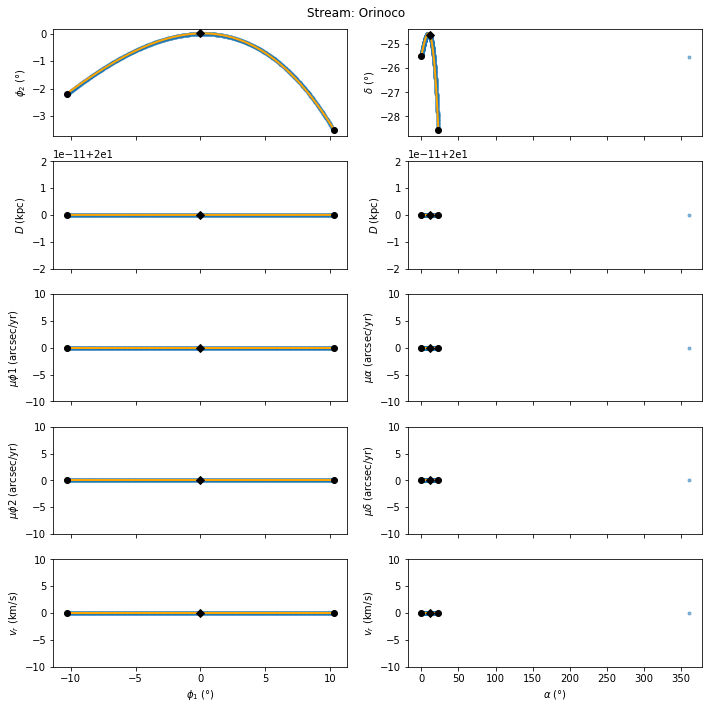

In [310]:
ra = np.linspace(0.,360.,10000)
dec = -25.5146 + 0.1672*ra -0.003827*ra**2 -0.0002835*ra**3 -5.3133e-6*ra**4
ra,dec=ra[np.abs(dec)<=90],dec[np.abs(dec)<=90]
maskb=(ra>(360-36)) | (ra<23) 
ra,dec=ra[maskb],dec[maskb]
zeros=np.zeros(ra.size)
#width=0.5*u.deg
D = 20.0+zeros
#Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
#D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

Ref = "grillmair2017"
Name,ShortName= "Orinoco","Ori"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

Kwando
=====

Kwando -> track.st.Kwando.grillmair2017.ecsv


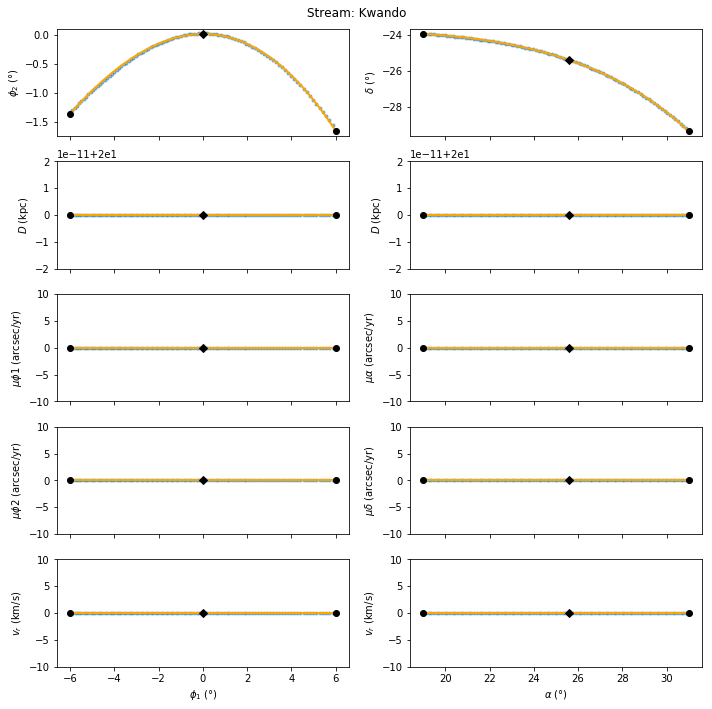

In [305]:
ra = np.linspace(19.,31.,100)
dec = -7.817 -2.354*ra +0.1202*ra**2 -0.00215*ra**3 
D=20*np.ones_like(ra)
zeros=np.zeros(ra.size)

Ref = "grillmair2017"
Name,ShortName= "Kwando","Kaw"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

Orphan
=======

The track for the Orphan stream is realised from the knots reported in Koposov2019 for the sky, distance and pm_phi1 track. These were derived by fitting Gaia DR2 data for RR Lyrae stars selected as stream candidates with simple tangential velocity and XX filters. The pm_phi2 corresponds to that in Fig.~1 of Erkal2019 (kindly supplied by D. Erkal, priv. comm.).

pm_phi2 in the plot is not zero because the auto-computed stream frame is not identical to the original frame in which pm_phi2 was zero.

I need to implement a keyword for the user pass a custom stream_frame that overrides the auto-computed one. Same as for the mid_point.

Orphan -> track.st.Orphan.koposov2019.ecsv


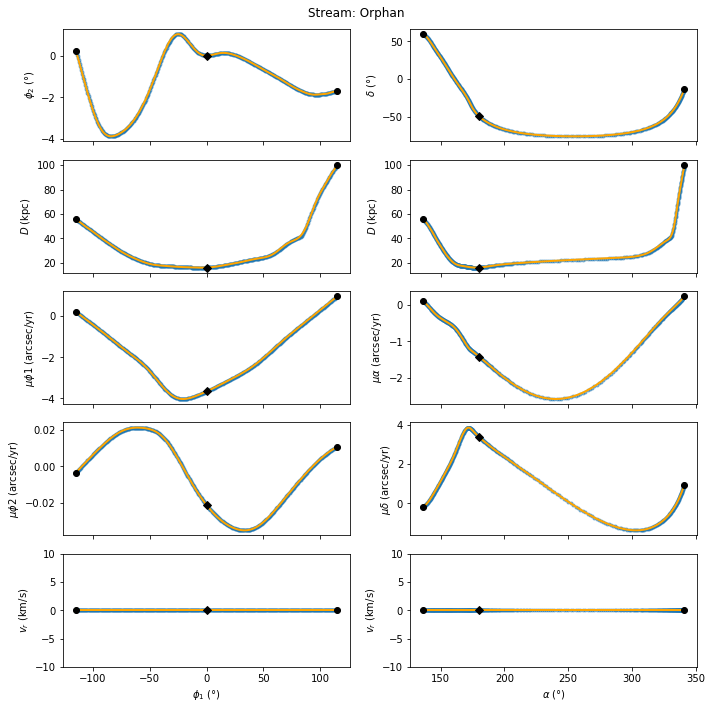

In [312]:
#Orphan footprint from Koposov et al. 2019 - Gaia DR2 RRLs.

#Knots for D(phi1) interpolation
phi1_Dknot=np.array([-100.0,-76.2169,-69.9684,-63.1307,-44.2712,-25.0268,-5.3975,20.0052,42.3287,61.958,90.0548,114.3027])   
Dknot=np.array([100.0,58.0,44.0,39.441,27.6252,22.5353,18.7178,15.9911,16.9,18.5361,29.2612,44.8945])
#phi1-phi2
#Knots for phi2(phi1) stream track interpolation
phi1k=np.array([-105.186,-74.7184,-54.4067,-25.4375,0.2019,25.8413,39.1605,66.9643,93.1032,108.0872,129.8974,162.5293])
phi2k=np.array([2.315,2.148,1.2797,-0.0562,-0.8577,-1.1917,-1.9598,1.1127,3.2835,3.2167,-0.1564,-4.8653])
#Interpolators
orphan_Dspline=scipy.interpolate.CubicSpline(phi1_Dknot,Dknot,bc_type='natural',extrapolate=True)
orphan_phi2spline=scipy.interpolate.CubicSpline(phi1k,phi2k,bc_type='natural')

#Pmphi1 interpolator
phi1_mu1_knots=[]
phi2_mu1_knots=[]

x=np.array([-77.4458, 0.0408, -49.626, 1.3103, -28.3432, 2.3325, -2.1956, 3.1889, 24.2559, 3.881, 44.0186, 3.9108, 65.9096, 2.6219, 88.4086, 1.569, 103.6106, 
          0.8984, 124.7415, 0.0051])
phi1_mu1_knots=x[::2]
phi2_mu1_knots=x[1::2]
orphan_muphi1_spline=scipy.interpolate.CubicSpline(phi1_mu1_knots,phi2_mu1_knots,bc_type='natural',extrapolate=True)


# print(phi1_mu1_knots)
# print(phi2_mu1_knots)


#Plot to check
phi1s=np.linspace(-100,130,500)
Ds=orphan_Dspline(phi1s)
phi2s=orphan_phi2spline(phi1s)
muphi1s=orphan_muphi1_spline(phi1s)
zeros=np.zeros(phi1s.size)

#Rotation matrix from Koposov+ 2019 appendix
Mrot_radec_to_phi12=[[-0.44761231,-0.08785756,-0.88990128],
                     [-0.84246097,0.37511331,0.38671632],
                     [0.29983786,0.92280606,-0.2419219]]

stream_frame = gc.GreatCircleICRSFrame.from_R(Mrot_radec_to_phi12)
stream_track = ac.SkyCoord(phi1=phi1s*u.deg, phi2=phi2s*u.deg, distance=Ds*u.kpc, frame=stream_frame,
                           pm_phi1_cosphi2=muphi1s*u.mas/u.yr, pm_phi2=zeros*u.mas/u.yr)

Ref = "koposov2019"
Name,ShortName= "Orphan","Orp"

obs = stream_track.icrs

generate_track_from_points_plot_and_store(obs, Name, Ref, deg=25, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

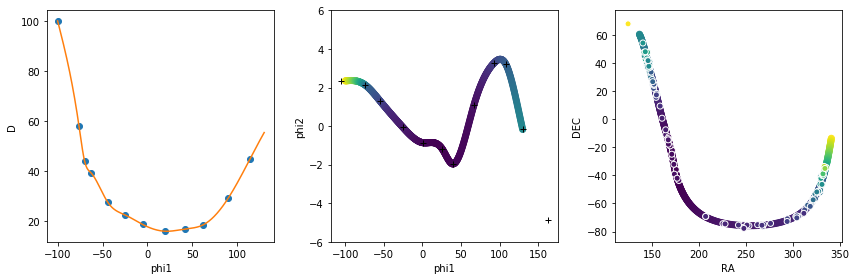

In [274]:
plt.figure(1,figsize=(12,4))
plt.subplot(131)
plt.plot(phi1_Dknot,Dknot,'o')
plt.plot(phi1s,Ds,'-')
plt.xlabel("phi1")
plt.ylabel("D")
plt.subplot(132)
plt.plot(phi1k,phi2k,'k+')
plt.scatter(phi1s,phi2s,c=Ds,marker='o')
plt.ylim(-6,6)
plt.xlabel("phi1")
plt.ylabel("phi2")

#Double check coordinate rotation with OATs RRLs 
rrs=pd.read_csv("/Users/cmateu/trabajo/research/aspen_orphan/orphan_rrl_members.alldata.csv")
plt.subplot(133)
#plt.scatter(ras,decs,c=Ds,marker='o')
plt.scatter(stream_track.icrs.ra.value,stream_track.icrs.dec.value,c=stream_track.distance.value,marker='o')
plt.scatter(rrs.RA,rrs.DEC,c=rrs.DIST,marker='o',edgecolors='w')
plt.xlabel("RA")
plt.ylabel("DEC")

plt.tight_layout()

Tri-Pis (Triangulum stream Bonaca et al. 2012)
===


Tri-Pis -> track.st.Tri-Pis.grillmair2017.ecsv


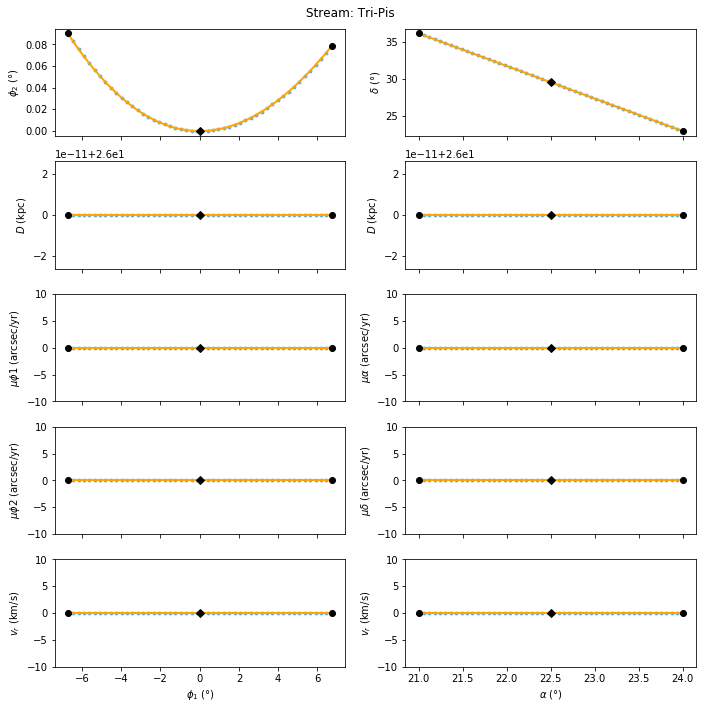

In [318]:
#DEC = 4.4*RA + 128.5; with 21<RA>24
#Bonaca2012 mean distance adopted for the stream
ra=np.linspace(21,24,50)
dec = -4.4*ra + 128.5
D = 26.*np.ones(ra.size)
width=0.2*u.deg
zeros=np.zeros(ra.size)

Ref = "grillmair2017"
Name,ShortName= "Tri-Pis","TriPis"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)


NGC5466
====

#Old realization
#Middle point  are central coords of NGC5466 from Harris1997 (2010ed),
#Heliocentric distance also from Harris1997 (2010ed)
#Stream end points are from Grillmair & Johnson 2006, Fig 1 caption

Initially detected by Belokurov et al. 2006 (https://iopscience.iop.org/article/10.1086/500362/pdf) within $\sim3^\circ$ of the cluster center. Later photometric follow-up by Grillmair & Johnson 2006 revealed  tails of XX longitude.

Current realization: Points were read-off of figure 2 of Grillmair & Johnson 2006 following the dot-dashed line as a guide. Extraction made with WebPlotDigitizer (https://apps.automeris.io/wpd/)

Interesting to note that Weiss et al. 2018 report three detections near but about $\sim 5^\circ$ south of the NGC5466 stream reported by Grillmair & Johnson 2006 (see utility plot below)

NGC5466 -> track.st.NGC5466.grillmair2006.ecsv


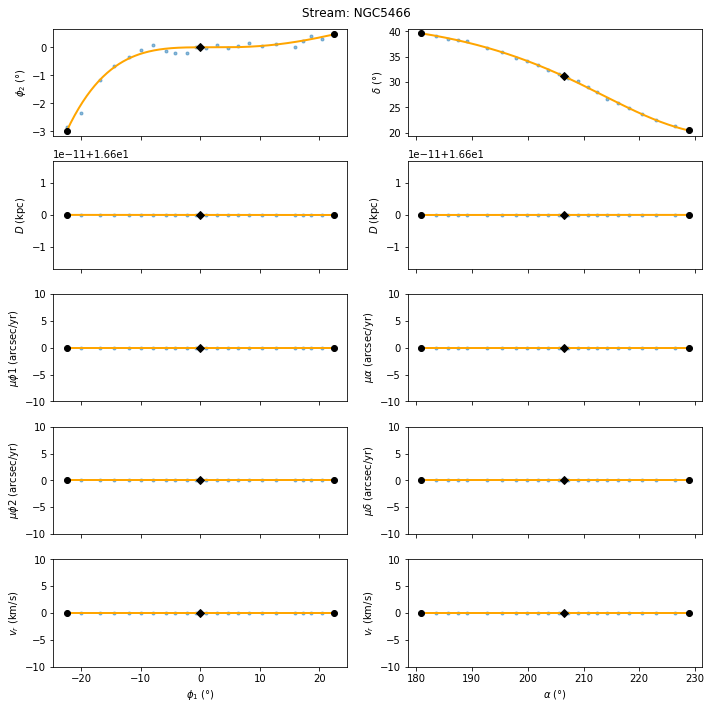

In [29]:
#RA     DEC     D     Center
#180.    42.     16.6  0
#211.36  28.53   16.6  1
#228.    21.     16.6  0
# ra = np.array([180.,211.36,228.])
# dec = np.array([42., 28.53, 21.])
# D = 16.6*np.ones(ra.size)
# zeros=np.zeros(ra.size)

tr = np.array([228.73, 20.34, 226.45, 21.43, 222.97, 22.52, 220.51, 23.61, 218.12, 24.81, 216.12, 25.78, 214.18, 26.76, 212.35, 28.13, 
               210.81, 29.10, 208.93, 30.13, 207.22, 30.76, 205.68, 31.56, 203.68, 32.42, 201.80, 33.40, 
               199.86, 34.14, 197.86, 34.83, 195.46, 35.86, 192.72, 36.77, 189.07, 38.03, 187.42, 38.26, 185.76, 38.55, 183.54, 39.18, 180.91, 39.58])
ra,dec = tr[::2],tr[1::2]
D = 16.6*np.ones(ra.size)
zeros=np.zeros(ra.size)

Ref = "grillmair2006"
Name,ShortName= "NGC5466","NGC5466"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, deg=5, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)



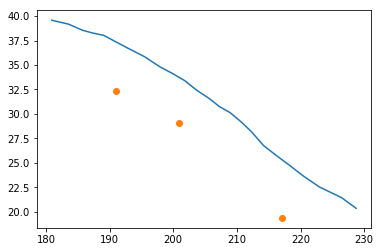

In [34]:
plt.plot(obs.ra, obs.dec,'-')
l=[18.8,49.7,140.2]
b=[66.5,82.6,84.5]
w = ac.SkyCoord(l=l,b=b,unit=u.deg,frame='galactic')
plt.plot(w.icrs.ra,w.icrs.dec,'o')

Cetus or Cetus Polar Stream
====
Yanny, B., Newberg, H. J., Johnson, J. A., et al. 2009, ApJ, 700, 1282

Newberg, H. J., Yanny, B., & Willett, B. A. 2009, ApJ, 700, L61

Discovered by Yanny et al. 2009 and confirmed as an overdensity near the Sgr trailing by Newberg et al. 2009 using SEGUE.
Yam et al. 2013 follo-up and provide a sky, distance and radial velocity track (5 points reported in Table 1)

Yam et al. report the measured radial velocities in the GSR. The authors do not explicitly state the solar parameters assumed to convert the observed radial velocities to the GSR. To revert back to the heliocentric frame and compute the observed radial velocity we assume $(U,V,W)=(10.3,232.6,5.9)$~km/s from Schoenrich & Binney 2010.

Cetus -> track.st.Cetus.grillmair2006.ecsv


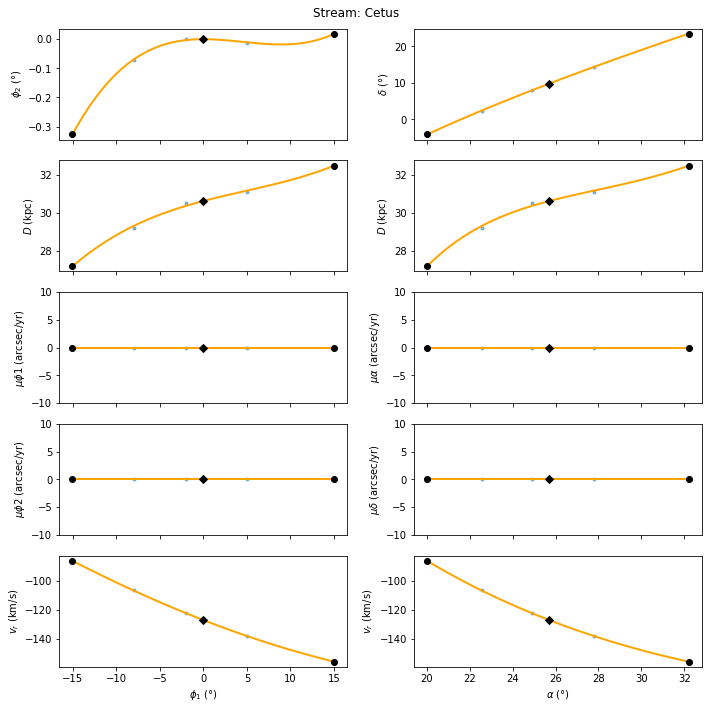

In [14]:
#Galstreams 1 table had l vector flipped.
#Table 1 from Yam et al. 2013. For b we take the middle of the range reported in the table
tr = np.array([140.7,  -66, 27.2, 142.,  -59., 29.2, 143.,  -53., 30.5, 144.,  -46., 31.1, 145.,  -36., 32.5])
l, b, D = tr[::3],tr[1::3],tr[2::3]
Vgsr = np.array([-35.2, -42.2, -47.8, -53.0, -57.9])
zeros=np.zeros(l.size)

Ref = "grillmair2006"
Name,ShortName= "Cetus","Cet"

obs = ac.SkyCoord(l=l*u.deg, b=b*u.deg, distance=D*u.kpc, frame='galactic')

#Convert Vgsr back to heliocentric, using Schoenrich & Binney 2010. This is a guess. This is not explicitly mentioned in Yam et al. 2013.
vhel = gc.vgsr_to_vhel(coordinate=obs,vgsr=Vgsr*u.km/u.s,vsun=(10.3,232.6,5.9)*u.km/u.s)

obs = ac.SkyCoord(l=l*u.deg, b=b*u.deg, distance=D*u.kpc, frame='galactic',
                 pm_l_cosb=zeros*u.mas/u.yr, pm_b=zeros*u.mas/u.yr, radial_velocity=vhel)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=3, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)


**300S = The 300 km/s stream**
================================================


First discovered by simon et al. 2011 who noted an excess of stars with a heliocentric radial velocity of 300km/s in a field towards Segue 1, suggesting that due to their extension they must belong to a stream. Later confirmed by Bernard et al. 2016 with PS1 data / Further follow-up to indentify the photometric counterpart was done by Niederste-Ostholt et al. (2009) wtih SDSS and Bernard et al. 2016 PS1, tracing the feature over the range $144<RA<168$. Fu2018 conducts spectroscopic follow-up with APOGEE-2 and SEGUE data.

The stream sky, distance and radial velocity tracks are taken from the orbit fit provided by Fu2018 in their Figure 10. Note that, the stream members observed and confirmed spectroscopically by Fu2018 and, thus, the orbital fit gives a sky track that differs slightly from the one reported by B16. At both ends the B16 track is a bit south of the one in Fu2018. F18 also notes the B16 track extends further than theirs, they restrict the track to the area where the stream is most prominent.

300S -> track.st.300S.fu2018.ecsv


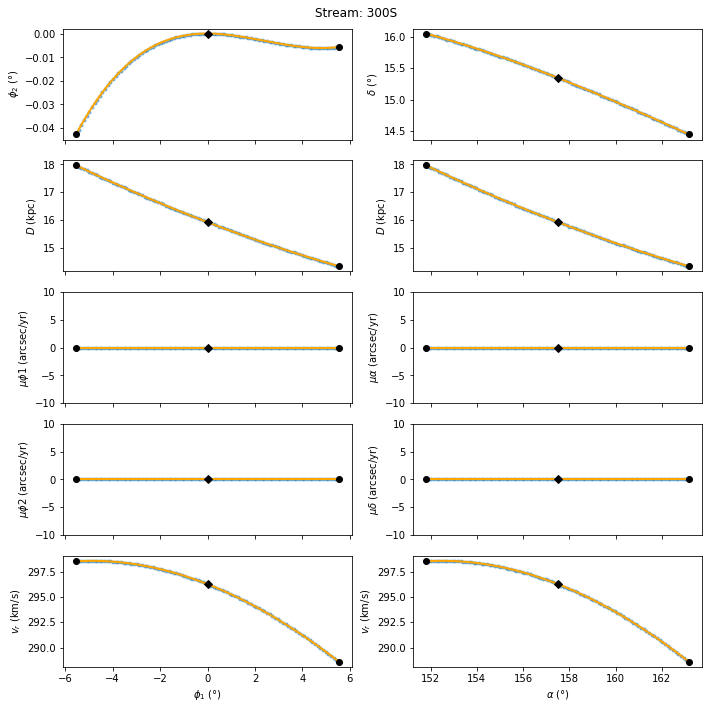

In [37]:
tr = [163.86, 14.33, 162.25, 14.60, 160.97, 14.83, 159.65, 15.01, 158.70, 15.16, 157.83, 15.31, 156.94, 15.43, 
       155.89, 15.55, 155.05, 15.68, 154.25, 15.78, 153.41, 15.88, 152.75, 15.96, 151.77, 16.04, 150.81, 16.14]
ra,dec = tr[::2][::-1],tr[1::2][::-1]
dec_spline = np.poly1d(np.polyfit(ra,dec, deg=3))

tr = [163.42, 288.04, 162.80, 289.35, 161.76, 291.03, 160.42, 292.90, 159.00, 294.77, 157.60, 296.07, 154.86, 298.13, 153.38, 298.50, 151.80, 298.50]
ra, vrad = tr[::2][::-1],tr[1::2][::-1]
vrad_spline = np.poly1d(np.polyfit(ra,vrad, deg=3))

tr = [163.17, 14.37, 161.86, 14.64, 160.20, 15.12, 158.54, 15.64, 156.71, 16.18, 155.11, 16.74, 153.86, 17.17, 152.69, 17.60, 151.80, 17.98]
ra, dist = tr[::2][::-1],tr[1::2][::-1] 
D_spline = np.poly1d(np.polyfit(ra,dist, deg=3))

#interpolate
ras=np.linspace(np.min(ra),np.max(ra),100)
decs = dec_spline(ras)
Ds = D_spline(ras)
vrads = vrad_spline(ras)
zeros=np.zeros(ras.size)

Ref = "Fu2018"
Name,ShortName= "300S","300S"

obs = ac.SkyCoord(ra=ras*u.deg, dec=decs*u.deg, distance=Ds*u.kpc, frame='fk5',
                  pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr, radial_velocity=vrads*u.km/u.s)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=3, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)



Parallel stream
================

Discovered by Sohn et al. 2016. Track from Weiss et al. 2018.

Parallel -> track.st.Parallel.weiss2018.ecsv


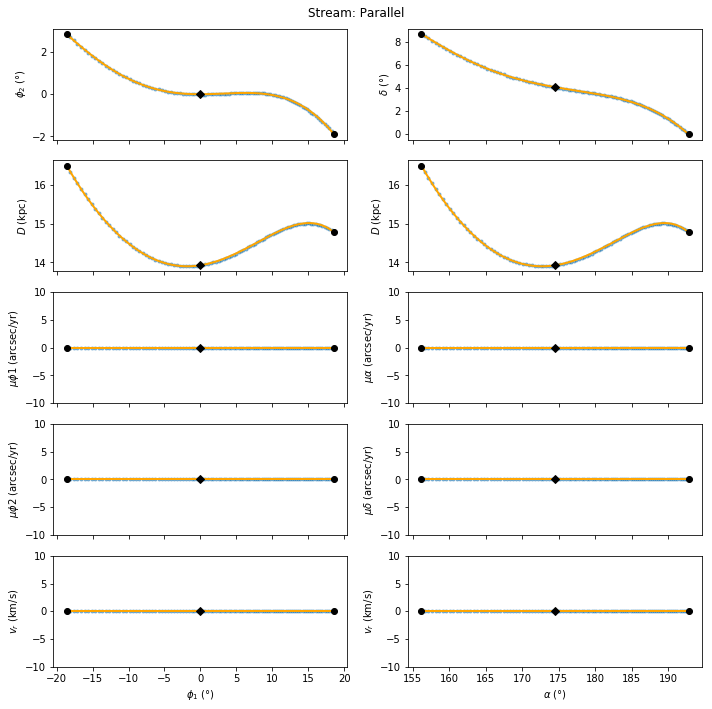

In [13]:
l = [302.8, 288.0, 253.7, 233.9]
b = [62.9, 64.6, 58.4, 50.8]
D = [14.8, 14.9, 14.0, 16.5]

b_fit = np.poly1d(np.polyfit(l,b, deg=3))
D_fit = np.poly1d(np.polyfit(l,D, deg=3))

ls = np.linspace(np.min(l),np.max(l),100)
bs = b_fit(ls)
Ds = D_fit(ls)

zeros=np.zeros(ls.size)

Ref = "Weiss2018"
Name,ShortName= "Parallel","Par"

obs = ac.SkyCoord(l=ls*u.deg, b=bs*u.deg, distance=Ds*u.kpc, frame='galactic',
                 pm_l_cosb=zeros*u.mas/u.yr, pm_b=zeros*u.mas/u.yr)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=5, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)



Perpendicular Stream - Weiss et al. 2018
====
Discovered by Sohn et al. 2016. Track from Weiss et al. 2018.

Perpendicular -> track.st.Perpendicular.weiss2018.ecsv


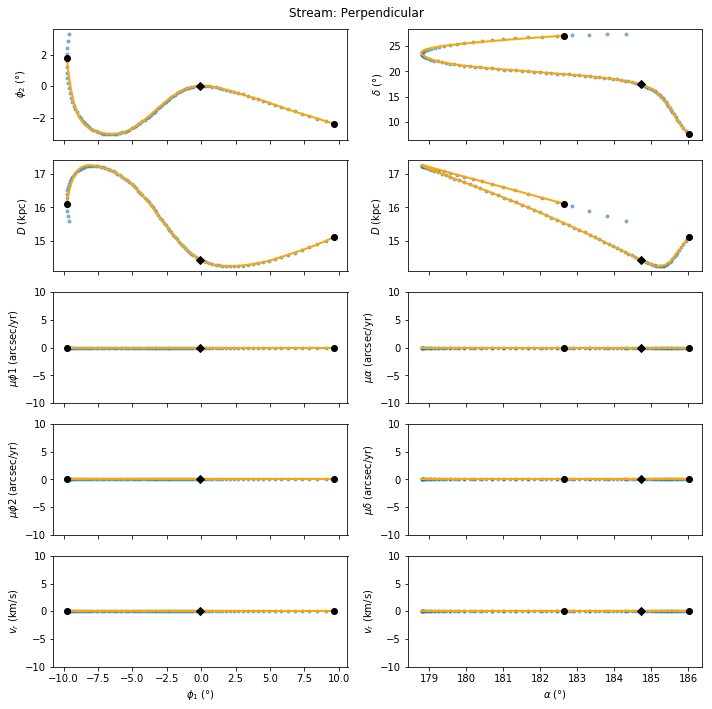

In [35]:
l = [283.4, 276.4, 245.4, 208.2]
b = [69.3, 73.8, 77.5, 82.4]
D = [15.1, 14.4, 16.0, 15.6]

b_fit = np.poly1d(np.polyfit(l,b, deg=3))
D_fit = np.poly1d(np.polyfit(l,D, deg=3))

ls = np.linspace(np.min(l),np.max(l),100)
bs = b_fit(ls)
Ds = D_fit(ls)

zeros=np.zeros(ls.size)

Ref = "Weiss2018"
Name,ShortName= "Perpendicular","Per"

obs = ac.SkyCoord(l=ls*u.deg, b=bs*u.deg, distance=Ds*u.kpc, frame='galactic',
                 pm_l_cosb=zeros*u.mas/u.yr, pm_b=zeros*u.mas/u.yr)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=13, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

Pegasus stream - Perottoni et al. 2019
====

We take the end points explicitly reported by Perottoni et al. 2019 in Table 1 and add a few manually selected points off of Figure 2 (to avoid assuming the track is well aproximated by a great circle). The authors report a single heliocentric distance of 18~kpc for the full stream.

Pegasus -> track.st.Pegasus.perottoni2019.ecsv


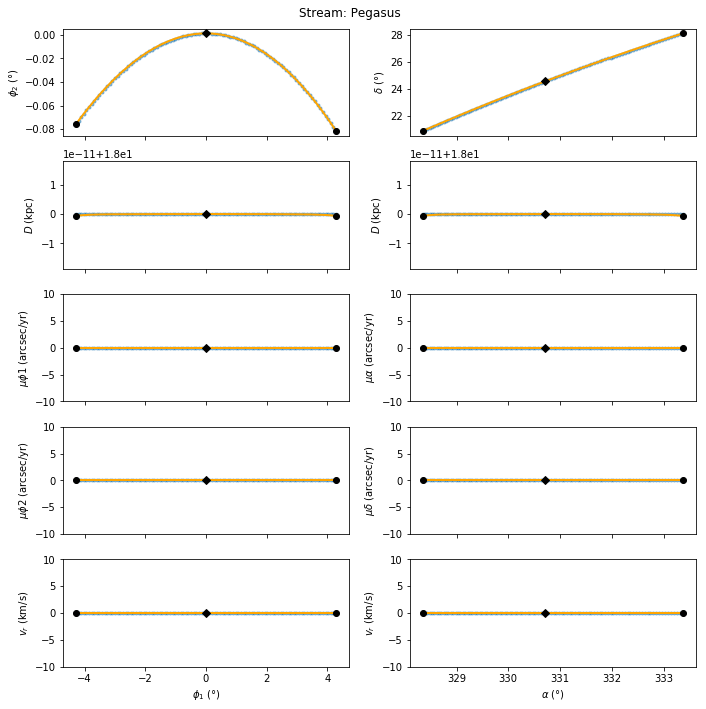

In [46]:
# ep_l = [76.4, 85.4]
# ep_b = [-25.5, -23.0]

tr = [76.4, -25.5, 79.35, -24.65, 81.00, -24.26, 82.66, -23.72, 83.63, -23.49, 85.4, -23.0]
l = tr[::2]
b = tr[1::2]
width = 0.4*u.deg

b_fit = np.poly1d(np.polyfit(l,b, deg=3))

ls = np.linspace(np.min(l),np.max(l),100)
bs = b_fit(ls)
Ds = 18.*np.ones(ls.size)
zeros=np.zeros(ls.size)

Ref = "Perottoni2019"
Name,ShortName= "Pegasus","Peg"

obs = ac.SkyCoord(l=ls*u.deg, b=bs*u.deg, distance=Ds*u.kpc, frame='galactic',
                 pm_l_cosb=zeros*u.mas/u.yr, pm_b=zeros*u.mas/u.yr)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=13, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

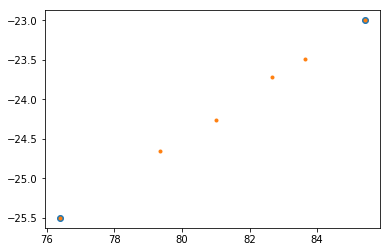

In [45]:
#to ensure continuity with end points
ep_l = [76.4, 85.4]
ep_b = [-25.5, -23.0]
plt.plot(ep_l,ep_b,'o')
plt.plot(l,b,'.')

M5 - Grillmair 2019
===

The tail is identified using a modified matched filter that weights the star's by how close they are to the predicted orbit for M5 using the cluster's Gaia DR2 proper motion. No figure shows observed data for the stream's candidate stars (they do show the orbit prediction) but they candidates (and weights) are reported in Table 1.
They have taken the cluster' proper motion from Gaia Collab 2018b. There's no information on how the solar reflex motion was subtracted.

We do not include velocity or distance track info as it would not correspond to a fit of the observations, but basically the orbital model prediction. 

M5 -> track.st.M5.grillmair2019.ecsv


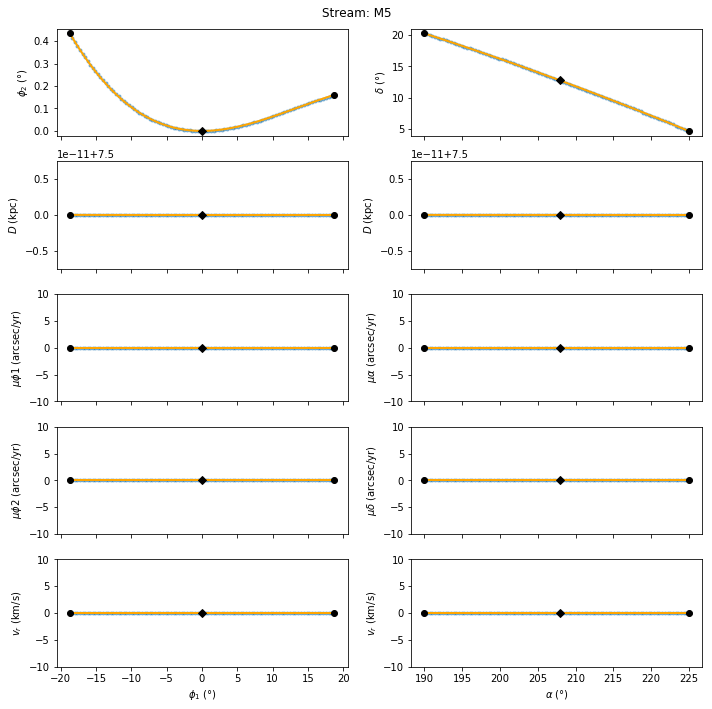

In [53]:
ra = np.linspace(190.,225.,100)
dec = 37.4026 + 0.2096*ra -0.001578*ra**2
zeros=np.zeros(ra.size)
D = 7.5*np.ones(ra.size)

Ref = "Grillmair2019"
Name,ShortName= "M5","M5"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                  pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr, radial_velocity=zeros*u.km/u.s)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=3, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)




M68
====

Palau & Miralda-Escudé 2018. Very similar procedure to that of Grillmair 2019 (this is an internal note). 

We use the stream candidate data reported in their Table E1 to derive the 5D track by polynomial fitting. The distance track is computed assuming 1/parallax as a distance estimator and excising stars with negative parallaxes and parallaxes < 1/20 which are clear outliers.

M68 -> track.st.M68.palau2019.ecsv


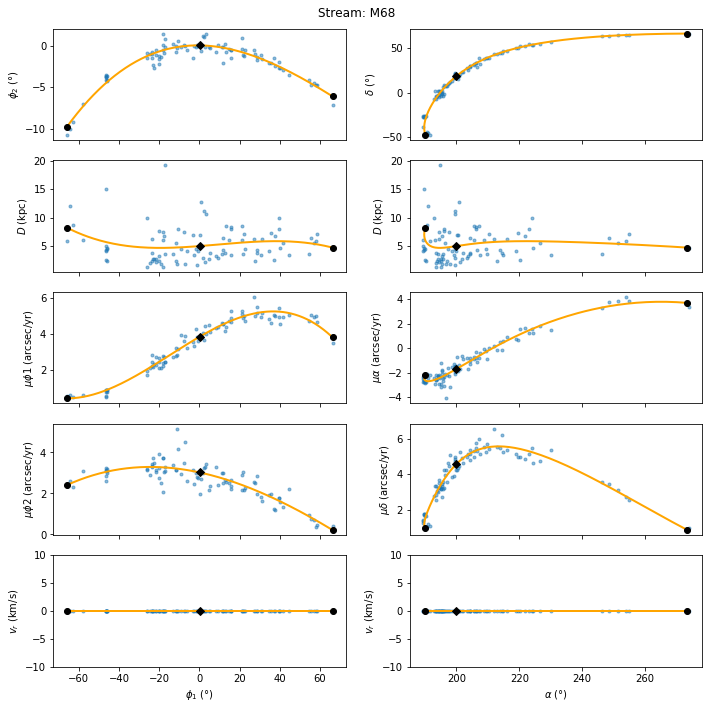

In [67]:
tt = astropy.io.ascii.read("../support_data/tableE1.palau2019.m68.csv",format='csv')
tt = tt[ (tt["parallax"]>0) & (1./tt['parallax']<20.)]

obs = ac.SkyCoord(ra=tt["ra"]*u.deg, dec=tt["dec"]*u.deg, distance=1./tt["parallax"]*u.kpc, 
                 pm_ra_cosdec=tt["muracosdec"]*u.mas/u.yr, pm_dec=tt["mudec"]*u.mas/u.yr, frame='icrs')

Ref = "Palau2019"
Name,ShortName= "M68","M68"


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=3, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)



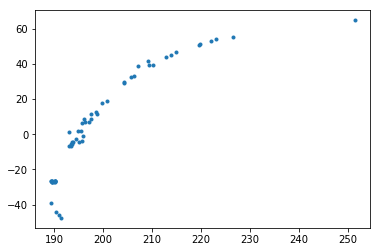

In [60]:
plt.plot(tt["ra"],tt["dec"],'.')

NGC3201
=====

Palau & Miralda-Escudé 2020. Mention that Gjoll is a section of the NGC3201 tails

/Users/cmateu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


NGC3201 -> track.st.NGC3201.palau2020.ecsv


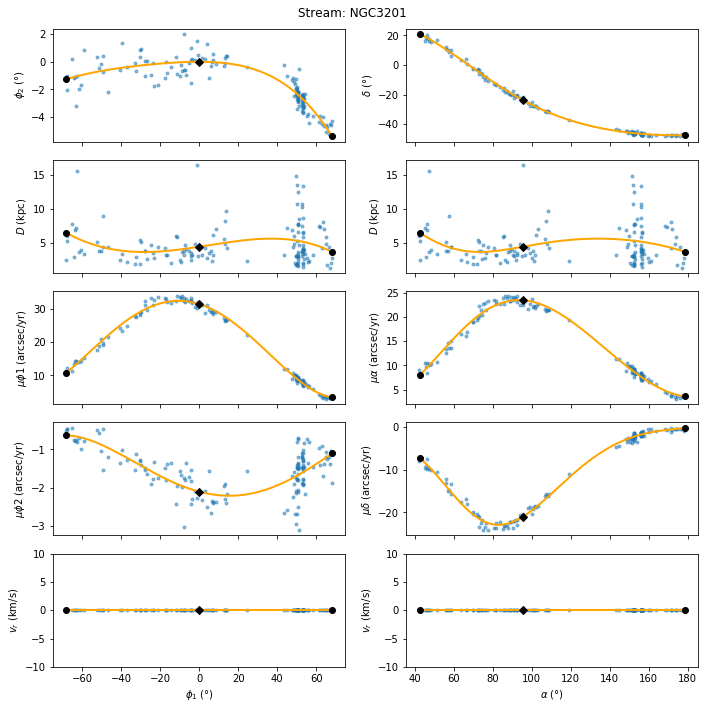

In [72]:
tt = astropy.io.ascii.read("../support_data/tableC1.palau2020.ngc3201.csv",format='csv')
tt = tt[ (tt["parallax"]>0) & (1./tt['parallax']<20.)]

obs = ac.SkyCoord(ra=tt["ra"]*u.deg, dec=tt["dec"]*u.deg, distance=1./tt["parallax"]*u.kpc, 
                 pm_ra_cosdec=tt["muracosdec"]*u.mas/u.yr, pm_dec=tt["mudec"]*u.mas/u.yr, frame='icrs')

Ref = "Palau2020"
Name,ShortName= "NGC3201","NGC3201"


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=4, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

AAU: ATLAS-AliqaUMa stream Li et al. 2020
=======

AAU-AliqaUMa -> track.st.AAU-AliqaUMa.li2020.ecsv


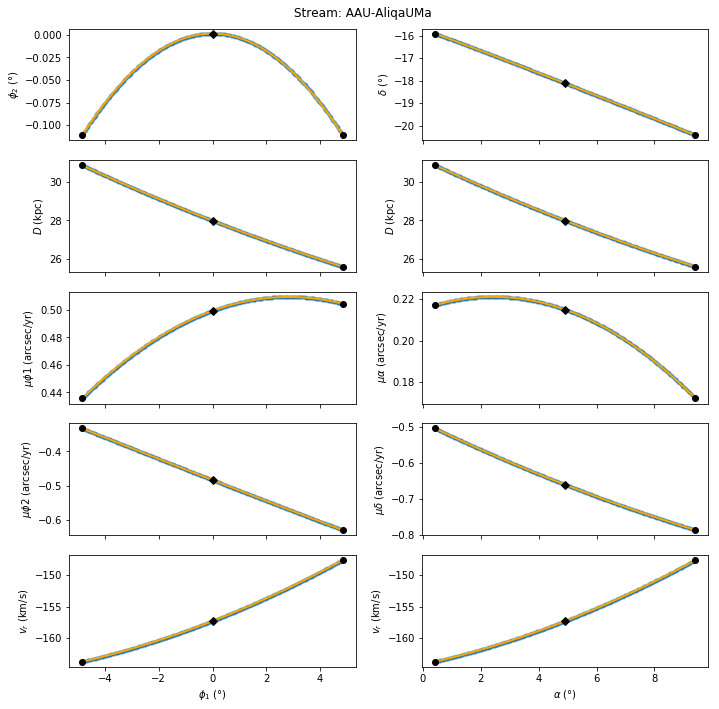

In [159]:
#interpolate
phi1s=np.linspace(-21,-11.5,300)

#track
delta = 1.5*np.ones(phi1s.size)
phi2s = delta -0.5*((phi1s-3.)/10.)**2


#VGSR, pms
x = phi1s/10.
VGSR = -131.33 + 0.07*x + 5.68*x**2
pm_ra_cosdec = -0.10-0.34*x-0.09*x**2
pm_dec = -0.96 -0.07*x +0.07*x**2

#mM
mM =16.66 -0.28*x + 0.045*x**2
D = 10**((mM+5)/5.)*1/1000.

zeros=np.zeros(phis.size)

R_radec_to_phi12= [[0.83697865, 0.29481904, -0.4610298],[0.51616778, -0.70514011, 0.4861566 ], [0.18176238, 0.64487142, 0.74236331]]

stream_frame = gc.GreatCircleICRSFrame.from_R(R_radec_to_phi12)
stream_track = ac.SkyCoord(phi1=phi1s*u.deg, phi2=phi2s*u.deg, distance=D*u.kpc, frame=stream_frame)

#Convert Vgsr back to heliocentric, using Schoenrich & Binney 2010. This is a guess. This is not explicitly mentioned in Yam et al. 2013.
vhel = gc.vgsr_to_vhel(coordinate=stream_track.icrs,vgsr=VGSR*u.km/u.s,vsun=(10.3,232.6,5.9)*u.km/u.s)

Ref = "Li2020"
Name,ShortName= "AAU-AliqaUMa","AAU-AU"

obs = ac.SkyCoord(ra=stream_track.icrs.ra, dec=stream_track.icrs.dec, distance=stream_track.distance, frame='icrs',
                  pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, pm_dec=pm_dec*u.mas/u.yr, radial_velocity=vhel)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=2, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)




AAU-ATLAS -> track.st.AAU-ATLAS.li2020.ecsv


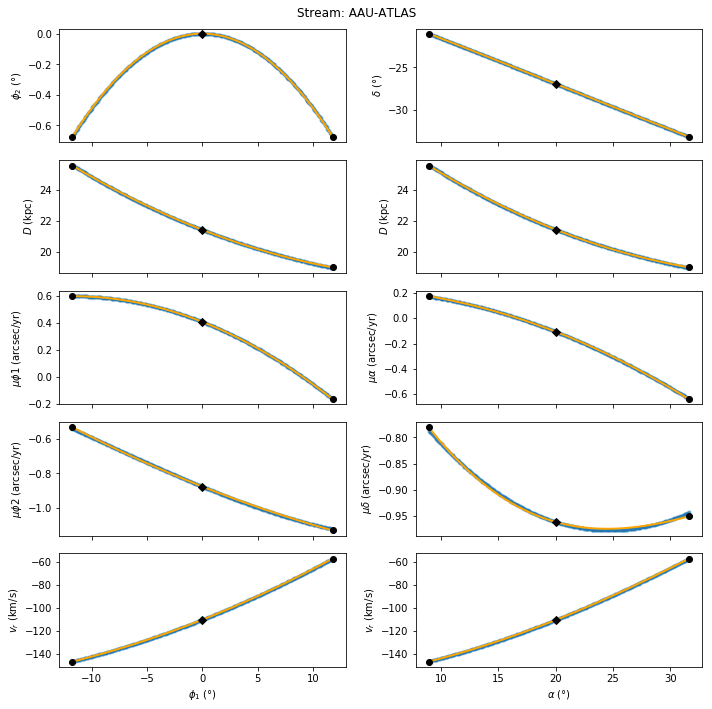

In [160]:
#interpolate
phi1s=np.linspace(-11.5,12,300)

#track
delta = 0.75*np.ones(phi1s.size)
phi2s = delta -0.5*((phi1s-3.)/10.)**2


#VGSR, pms
x = phi1s/10.
VGSR = -131.33 + 0.07*x + 5.68*x**2
pm_ra_cosdec = -0.10-0.34*x-0.09*x**2
pm_dec = -0.96 -0.07*x +0.07*x**2

#mM
mM =16.66 -0.28*x + 0.045*x**2
D = 10**((mM+5)/5.)*1/1000.

zeros=np.zeros(phis.size)

R_radec_to_phi12= [[0.83697865, 0.29481904, -0.4610298],[0.51616778, -0.70514011, 0.4861566 ], [0.18176238, 0.64487142, 0.74236331]]

stream_frame = gc.GreatCircleICRSFrame.from_R(R_radec_to_phi12)
stream_track = ac.SkyCoord(phi1=phi1s*u.deg, phi2=phi2s*u.deg, distance=D*u.kpc, frame=stream_frame)

#Convert Vgsr back to heliocentric, using Schoenrich & Binney 2010. This is a guess. This is not explicitly mentioned in Yam et al. 2013.
vhel = gc.vgsr_to_vhel(coordinate=stream_track.icrs,vgsr=VGSR*u.km/u.s,vsun=(10.3,232.6,5.9)*u.km/u.s)

Ref = "Li2020"
Name,ShortName= "AAU-ATLAS","AAU-A"

obs = ac.SkyCoord(ra=stream_track.icrs.ra, dec=stream_track.icrs.dec, distance=stream_track.distance, frame='icrs',
                  pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, pm_dec=pm_dec*u.mas/u.yr, radial_velocity=vhel)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=2, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)




Sgr
======

Computations for lib_by_pair or lib_by_pole
================================================================================================

Pal 15 and Eridanus
-------------------

Computed from position angle (PA) and length of the tails from Myeong+ 2017. For each cluster they report the PA and length *l* for the 'tail 1' and 'tail 2', the two tails coming out of the cluster.

In [174]:
#Pal 15
rac,decc=255.01,-0.5419
l1,PA1=59./60.,np.radians(340.)
l2,PA2=29./60.,np.radians(150.)

delta_ra1=l1*np.sin(PA1)/np.cos(np.radians(decc))
delta_dec1=l1*np.cos(PA1)
delta_ra2=l2*np.sin(PA2)/np.cos(np.radians(decc))
delta_dec2=l2*np.cos(PA2)

#print delta_ra1*np.cos(np.radians(decc)),delta_dec1
#print delta_ra2*np.cos(np.radians(decc)),delta_dec2

ra1,dec1=rac -delta_ra1,decc-delta_dec1
ra2,dec2=rac -delta_ra2,decc-delta_dec2

print(ra1, dec1)
print(ra2,dec2)

255.34633485050725 -1.4659310771061431
254.7683225240729 -0.12332105483752132


In [177]:
#Eridanus
rac,decc=66.1854,-21.1869
l1,PA1=18./60.,np.radians(40.)
l2,PA2=11./60.,np.radians(220.)

delta_ra1=l1*np.sin(PA1)/np.cos(np.radians(decc))
delta_dec1=l1*np.cos(PA1)
delta_ra2=l1*np.sin(PA2)/np.cos(np.radians(decc))
delta_dec2=l1*np.cos(PA2)

#print delta_ra1*np.cos(np.radians(decc)),delta_dec1
#print delta_ra2*np.cos(np.radians(decc)),delta_dec2

ra1,dec1=rac -delta_ra1,decc-delta_dec1
ra2,dec2=rac -delta_ra2,decc-delta_dec2

print(ra1, dec1)
print(ra2,dec2)

65.97858431221822 -21.416713332935696
66.39221568778179 -20.957086667064306


Jet Stream
----

133.7568582473552 -27.702345529649296
141.99825582365125 -17.81505042193316


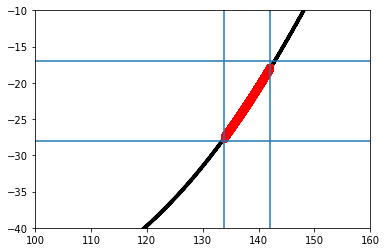

In [268]:
#props
dist=28.6 #kpc
width=0.18
#RA-DEC pole
gcra_all,gcdec_all=galstreams.gcutils.get_gc_for_pole(64.983, 34.747,degree=True,dlat=width)

plt.plot(gcra_all,gcdec_all,'k.',ms=1)

#Limit to reported RA and DEC ranges
ramin,ramax=15.*(8.+55./60.),15*(9.+28./60.)
decmin,decmax=-28.,-17.
#print ramin, ramax, decmin, decmax

jetmask=(gcra_all>=ramin) & (gcra_all<=ramax) & (gcdec_all>=decmin) & (gcdec_all<=decmax)
gcra_jet,gcdec_jet=gcra_all[jetmask],gcdec_all[jetmask]

plt.plot(gcra_jet,gcdec_jet,'ro')

plt.axvline(ramin)
plt.axvline(ramax)
plt.axhline(decmin)
plt.axhline(decmax)

plt.ylim(-40,-10)
plt.xlim(100,160)

#Print only end-points so this can be defined by lib_by_pair
print(gcra_jet[0],gcdec_jet[0])
print(gcra_jet[-1],gcdec_jet[-1])


Notes on Excluded Streams
===========

Icarus - Fiorentin et al. 2020 (arXiv:2012.10957v1)
-----

Identified in velocity space (U-V, V-W, Toomre diagram) with chemical data from GALAH and APOGEE-2. There is no celestial coordinate information in the paper. This stream is very close to the Sun (2.5kpc) and the stars probably surround it. It is excluded from the library.

Nyx - Necib et al. 2020
------

Nyx is a nearby stream of nearby stars identified kinematically by Necib et al. 2020. All the data is publicly available. It is also a stream in which the sun is embeded, so the stars are scattered all over the sky (see plot below). It is excluded from the library. 

In [9]:
Stars = pd.read_hdf('/Users/cmateu/Downloads/Public_SelectedByNetwork_5D.h5')

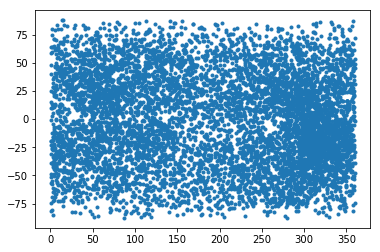

In [11]:
plt.plot(Stars["l"][::100],Stars["b"][::100],'.')

 S1-4 streams (Myeong et al. 2018)
 ---
*These streams/moving groups are too close or even surround the Sun, hence they are excluded from the library*

In [ ]:
#From Table 1, Myeong, et al. Monthly Notices RAS 475, 1537–1548 (2018). 
#Coordinates are galactocentric with Sun at +8.5 (approx., the paper is not explicit)
xyz_medians=[ (8.1,-0.2,2.8), (8.7,0.3,0.8), (8.6,0.5,3.5), (8.5,0.6,4.1)]
xyz_dispersions=[(0.8,1.2,1.9),(0.6,1.0,2.0), (1.1,1.5,1.9), (1.0,1.7,3.6)]
sns.set_style("whitegrid")
plt.figure(1,figsize=(12,8))
for ii in range(len(xyz_medians)):
    xs=np.random.normal(loc=xyz_medians[ii][0],scale=xyz_dispersions[ii][0],size=200)
    ys=np.random.normal(loc=xyz_medians[ii][1],scale=xyz_dispersions[ii][1],size=200)
    zs=np.random.normal(loc=xyz_medians[ii][2],scale=xyz_dispersions[ii][2],size=200)
    plt.subplot(2,4,ii+1)
    plt.title("S{0}".format(ii+1))
    plt.plot(xs,ys,'o',alpha=0.5)
    plt.grid(axis='both',which='both',lw=1)
    
    #Convert to heliocentric coords
#     ss=astropy.coordinates.SkyCoord(xs-8.5,ys,zs, unit='kpc',
#                                 representation='cartesian', frame='galactic')
    plt.subplot(2,4,5+ii)
#     plt.plot(ss.icrs.galactic.l,ss.icrs.galactic.b,'o',alpha=0.5)
    #Double check
    ll,bb,dd=bovyc.XYZ_to_lbd(xs-8.5,ys,zs,degree=True).T
    #plt.plot(ll,bb,'o',alpha=0.5)
    ssg=astropy.coordinates.SkyCoord(l=ll*astropy.units.deg,b=bb*astropy.units.deg,frame='galactic')
    plt.plot(ssg.l.wrap_at(180.*astropy.units.deg),ssg.b,'x')
plt.tight_layout()

#plt.plot(ssh.ra,ssh.dec,'o')

Extras - Playpen
====

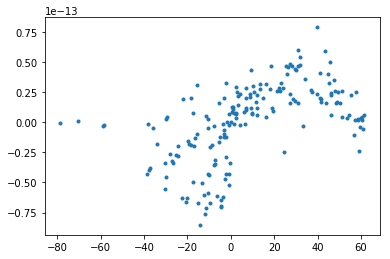

In [725]:
ibs.radial_velocity.min(),ibs.radial_velocity.max()
plt.plot(ibs.transform_to(stream_fr).phi1,ibs.transform_to(stream_fr).radial_velocity,'.')

In [726]:
ibs.transform_to(stream_fr).radial_velocity.min(),ibs.transform_to(stream_fr).radial_velocity.max()

(<Quantity -8.52602672e-14 km / s>, <Quantity 7.88789046e-14 km / s>)

Tests
======

In [266]:
#c_gc=c.transform_to(ac.Galactocentric)
#c_gc.spherical.lon